# 2. Selecione um sku (produto) e realize uma previsão da demanda do mesmo nos próximos 4 intervalos de tempo de sua escolha (dia, semana, mês, etc) 

* **métricas:** rmse, mape;

* **dados:** time_series_data.xlsx;

## 0.0. IMPORTS

In [311]:
import random
import pandas as pd
import warnings
import seaborn as sns
import numpy as np
import math
import xgboost as xgb
import datetime
import pickle
import json
import requests

from IPython.display import Image
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from dython.nominal import cramers_v
from pyod.models.knn import KNN
from matplotlib import pyplot as plt
from scipy.stats import boxcox
from category_encoders import MEstimateEncoder

### 0.1. Helper Functions

In [189]:
warnings.filterwarnings('ignore')

pd.set_option('display.float_format', lambda x: '%.2f' % x)

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display(HTML('<style>.container { width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set()
    
def describe(df, stats):
    d = df.describe()
    return d.append(df.reindex(d.columns, axis = 1).agg(stats))

def ml_error (model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse }, index=[0])

def cross_validation(x_training, kfold, model_name, model, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed(range(1, kfold+1)):
        if verbose:
            print( '\nKFold Number: {}'.format(k))
        # start and end date for validation
        validation_start_date = x_training['nota_data_emissao'].max() - datetime.timedelta (days = k*4*7)
        validation_end_date = x_training['nota_data_emissao'].max() - datetime.timedelta (days = (k-1)*4*7)
        
        # filtering dataset
        training = x_training[x_training['nota_data_emissao'] < validation_start_date]
        validation = x_training[(x_training['nota_data_emissao'] >= validation_start_date) & (x_training['nota_data_emissao'] <= validation_end_date)]
        
        # training and validation dataset
        # training
        xtraining = training.drop(['nota_data_emissao', 'produto_quantidade'], axis = 1)
        ytraining = training['produto_quantidade']
        
        # validation
        xvalidation = validation.drop(['nota_data_emissao', 'produto_quantidade'], axis = 1)
        yvalidation = validation['produto_quantidade']
        
        # model
        m = model.fit(xtraining, ytraining)
        
        # prediction
        yhat = m.predict(xvalidation)
        
        # performance
        m_result = ml_error (model_name, np.expm1(yvalidation), np.expm1(yhat))
        
        # store performance of each kfold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])
        
    return pd.DataFrame({'Model Name': model_name,
                         'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
                         'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
                         'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str)}, index=[0])

### 0.2. Loading Data

In [190]:
df_time_series_raw = pd.read_csv('datasets/time_series_data.csv')

In [191]:
df_time_series_raw.head()

,produto_descricao,produto_quantidade,produto_unidade_comercial,produto_valor_unitario_comercializacao,nota_data_emissao
0,A0,23568,UN,14.13,20210420
1,A0,25082,UN,14.13,20210420
2,A0,25430,UN,14.13,20210922
3,A0,25463,UN,12.84,20210209
4,A0,25800,UN,12.84,20210209


## 1.0. DESCRIÇÃO DE DADOS

In [192]:
df1 = df_time_series_raw.copy()

### 1.1. Data Info

In [193]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4460 entries, 0 to 4459
Data columns (total 5 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   produto_descricao                       4460 non-null   object 
 1   produto_quantidade                      4460 non-null   int64  
 2   produto_unidade_comercial               4460 non-null   object 
 3   produto_valor_unitario_comercializacao  4460 non-null   float64
 4   nota_data_emissao                       4460 non-null   int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 174.3+ KB


### 1.2. Change Data Types

In [194]:
df1['nota_data_emissao'] =  pd.to_datetime(df1['nota_data_emissao'], format='%Y%m%d')

In [195]:
df1.head()

,produto_descricao,produto_quantidade,produto_unidade_comercial,produto_valor_unitario_comercializacao,nota_data_emissao
0,A0,23568,UN,14.13,2021-04-20
1,A0,25082,UN,14.13,2021-04-20
2,A0,25430,UN,14.13,2021-09-22
3,A0,25463,UN,12.84,2021-02-09
4,A0,25800,UN,12.84,2021-02-09


### 1.3. Estatística Descritiva

In [196]:
num_attributes = df1.select_dtypes (include = ['float64', 'int64'])
cat_attributes = df1.select_dtypes (exclude = ['float64', 'int64', 'datetime64[ns]'])

### 1.3.1. Atributos Numéricos

In [197]:
describe(df1, ['skew', 'kurt'])

,produto_quantidade,produto_valor_unitario_comercializacao
count,4460.00,4460.00
mean,424.20,20.51
std,2036.97,44.43
min,0.00,0.62
25%,45.00,8.38
50%,72.00,11.42
75%,183.00,27.20
max,42000.00,1812.39
skew,11.12,29.99
kurt,143.18,1187.16


### 1.3.2. Atributos Categóricos

In [198]:
cat_attributes.apply (lambda x: x.unique().shape[0])

produto_descricao            32
produto_unidade_comercial     5
dtype: int64

<AxesSubplot: xlabel='produto_descricao', ylabel='produto_quantidade'>

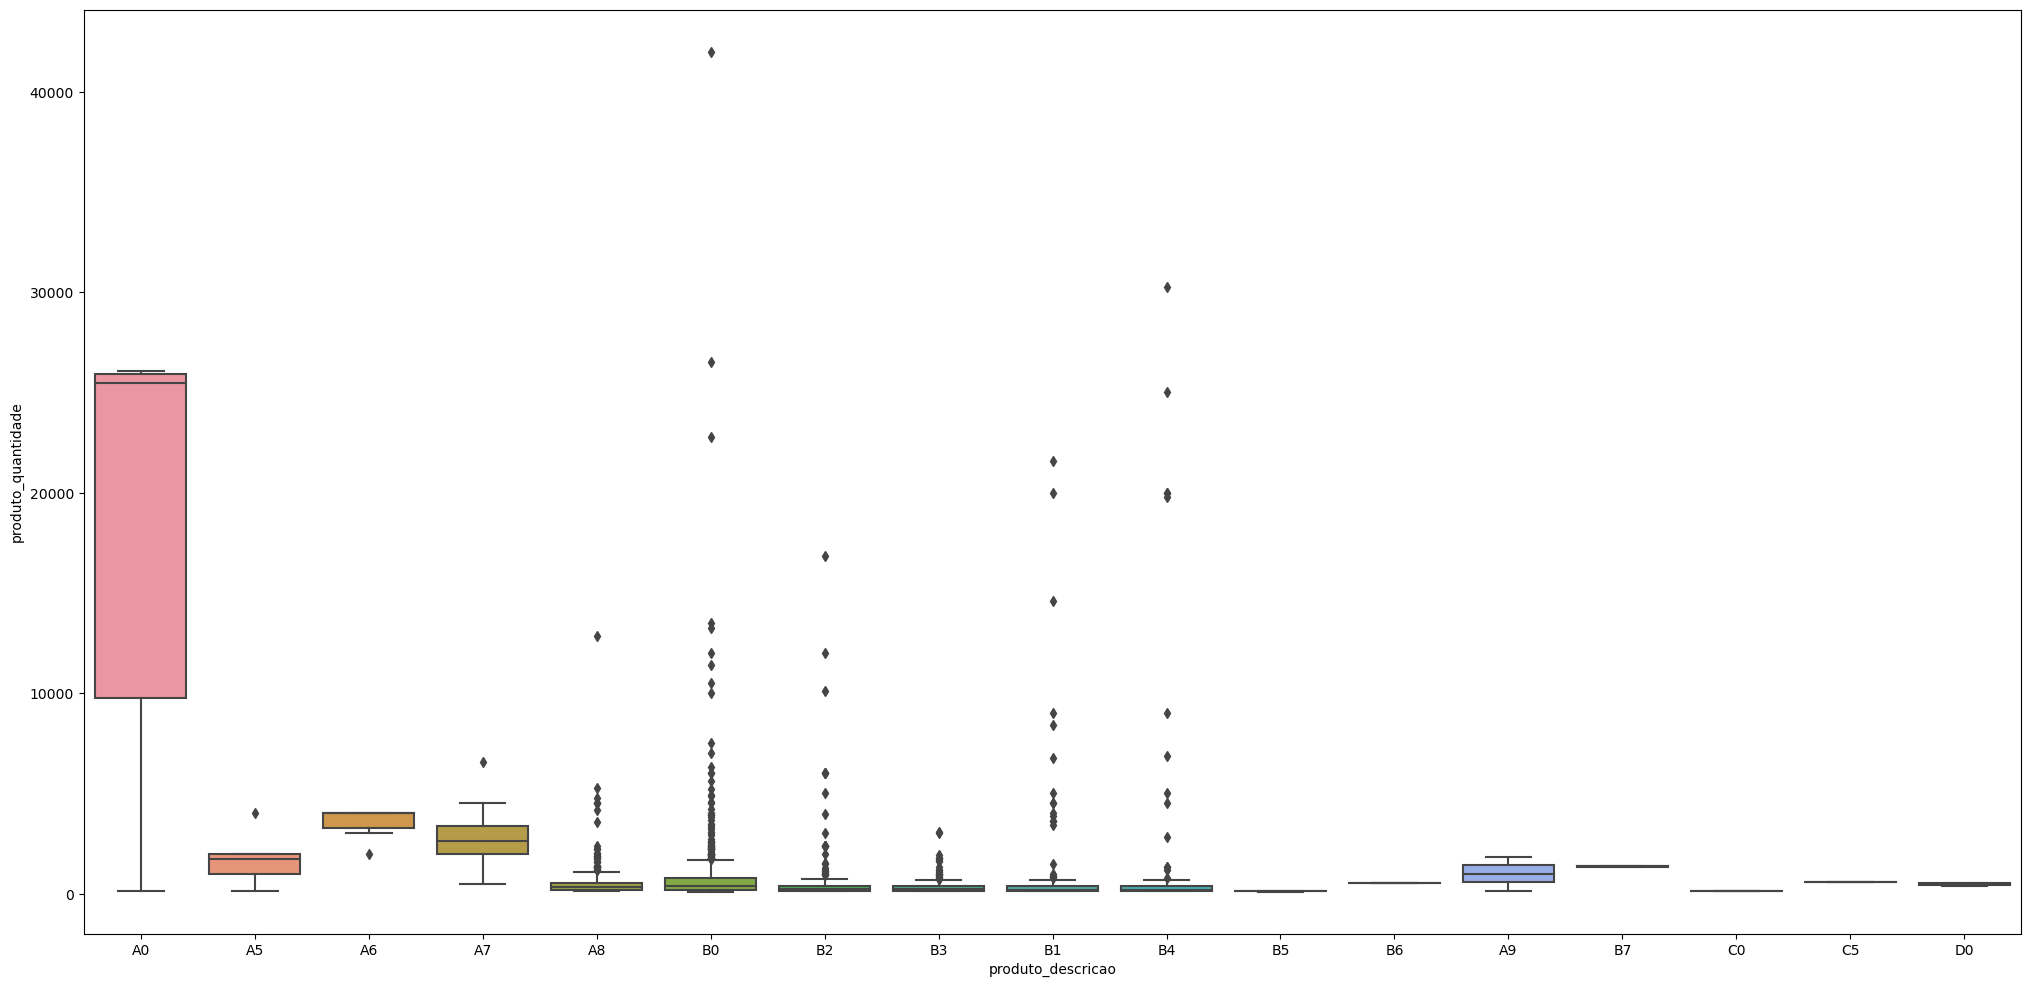

In [199]:
aux1 = df1[(df1['produto_quantidade'] > 100)]

plt.rcParams['figure.figsize'] = [25, 12]
sns.boxplot (x = 'produto_descricao', y = 'produto_quantidade', data = aux1)

**1.** Muitos tipos de produtos com pouca demanda no dataset.

**2.** O produto A0 possui um comportamento de compra muito diferente dos demais tipos.

**3.** Produto A8, B0, B2, B3, B1, B4 possuem bastante outliers, o que dificultará a previsão do model.

<AxesSubplot: xlabel='produto_unidade_comercial', ylabel='produto_quantidade'>

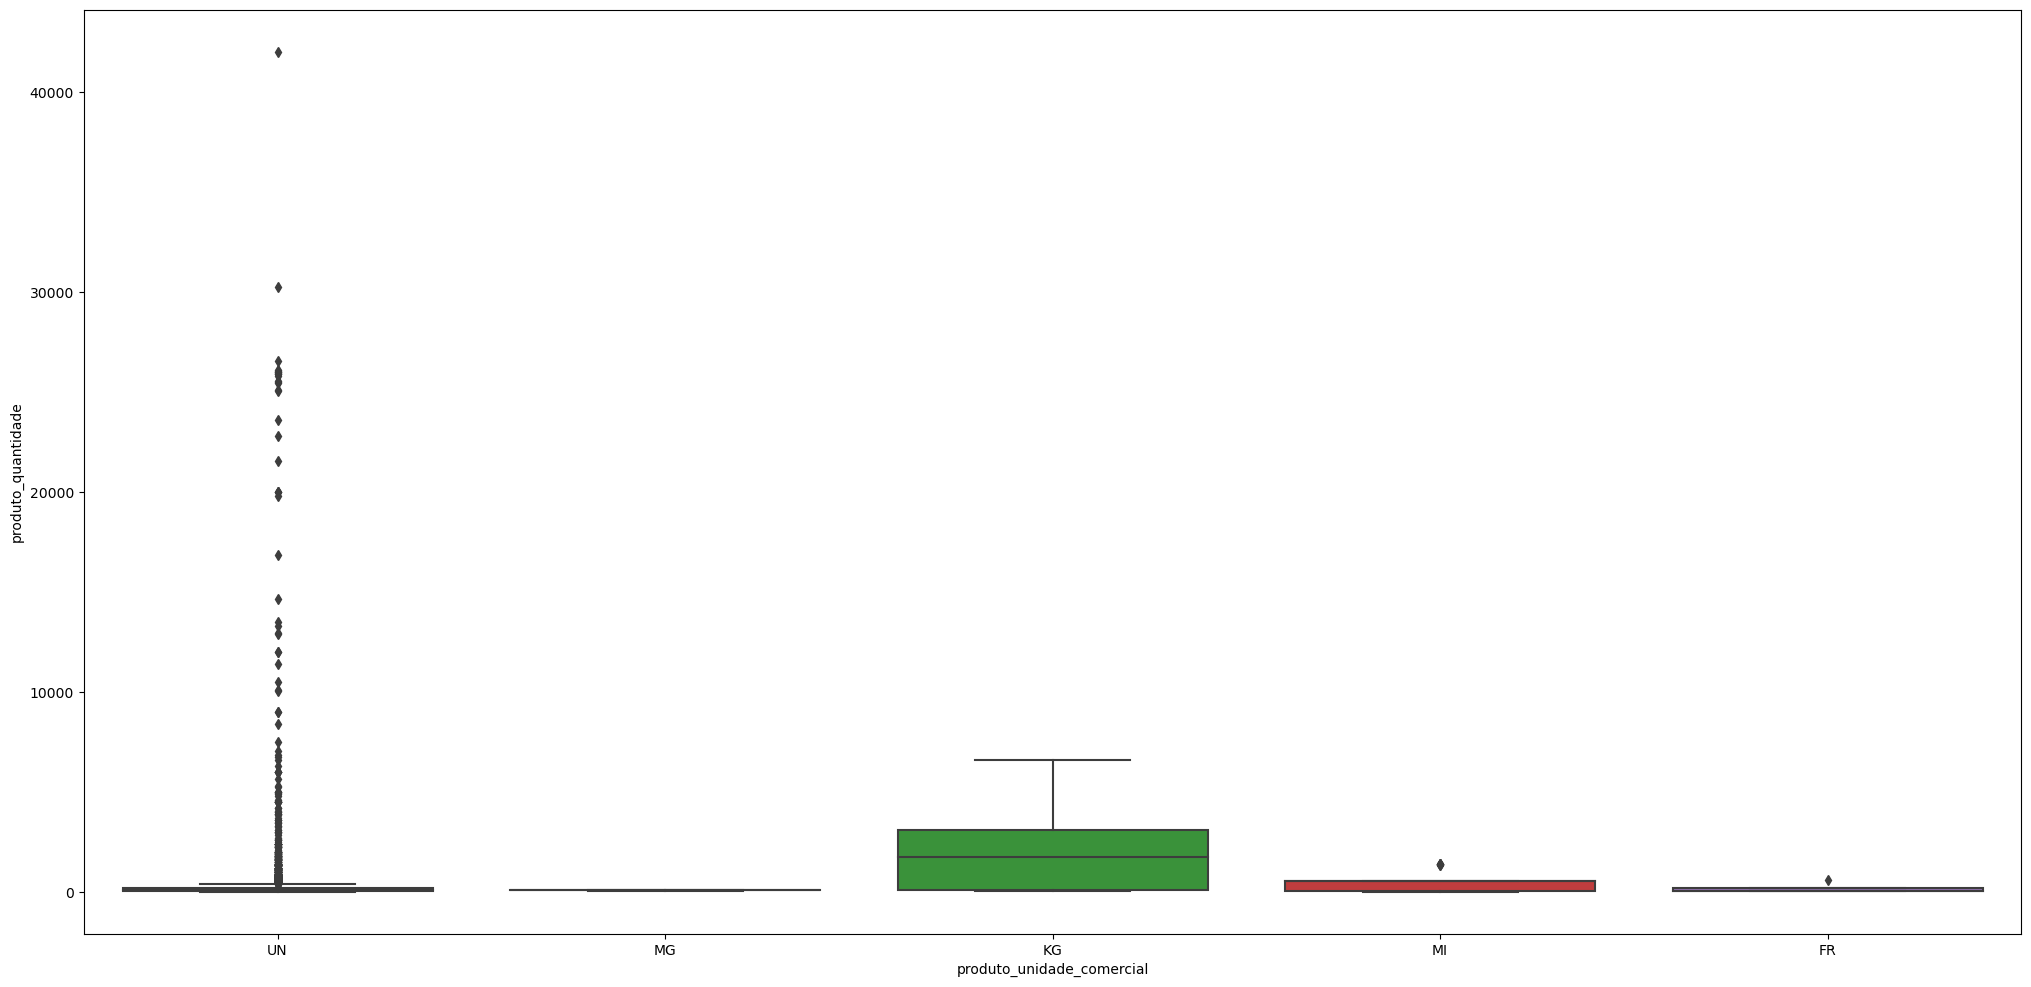

In [200]:
sns.boxplot (x = 'produto_unidade_comercial', y = 'produto_quantidade', data = df1)

**1.** Grande quantidade de Outliers

### 1.4. Outliers

In [201]:
detector = KNN()
detector.fit(df1.iloc[:,[1,3]])

KNN(algorithm='auto', contamination=0.1, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)

In [202]:
outlier = detector.labels_
np.unique(outlier, return_counts=True)

(array([0, 1]), array([4014,  446], dtype=int64))

In [203]:
outliers = []
for i in range(len(outlier)):
    if outlier[i] == 1:
        outliers.append(i)

In [204]:
df1 = df1.drop(labels=outliers, axis=0)

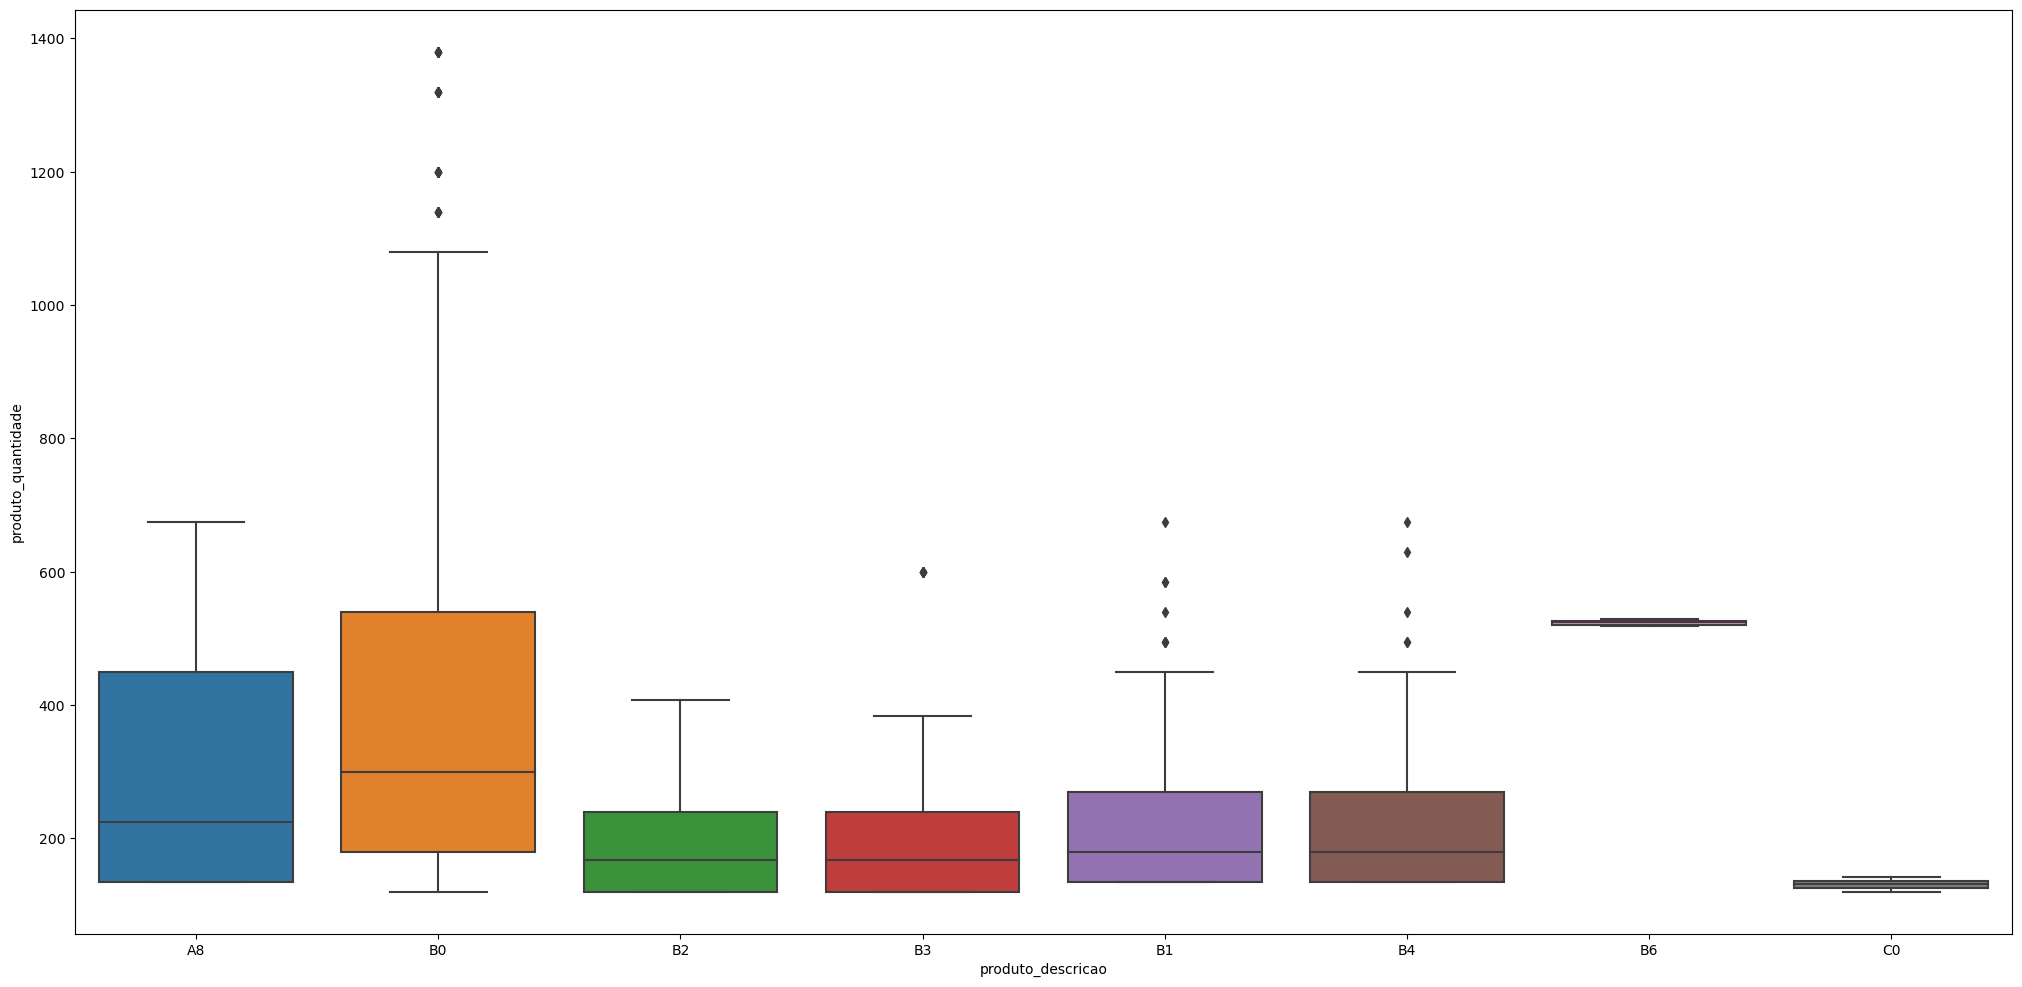

In [205]:
aux1 = df1[(df1['produto_quantidade'] > 100)]

plt.rcParams['figure.figsize'] = [25, 12]
sns.boxplot (x = 'produto_descricao', y = 'produto_quantidade', data = aux1);

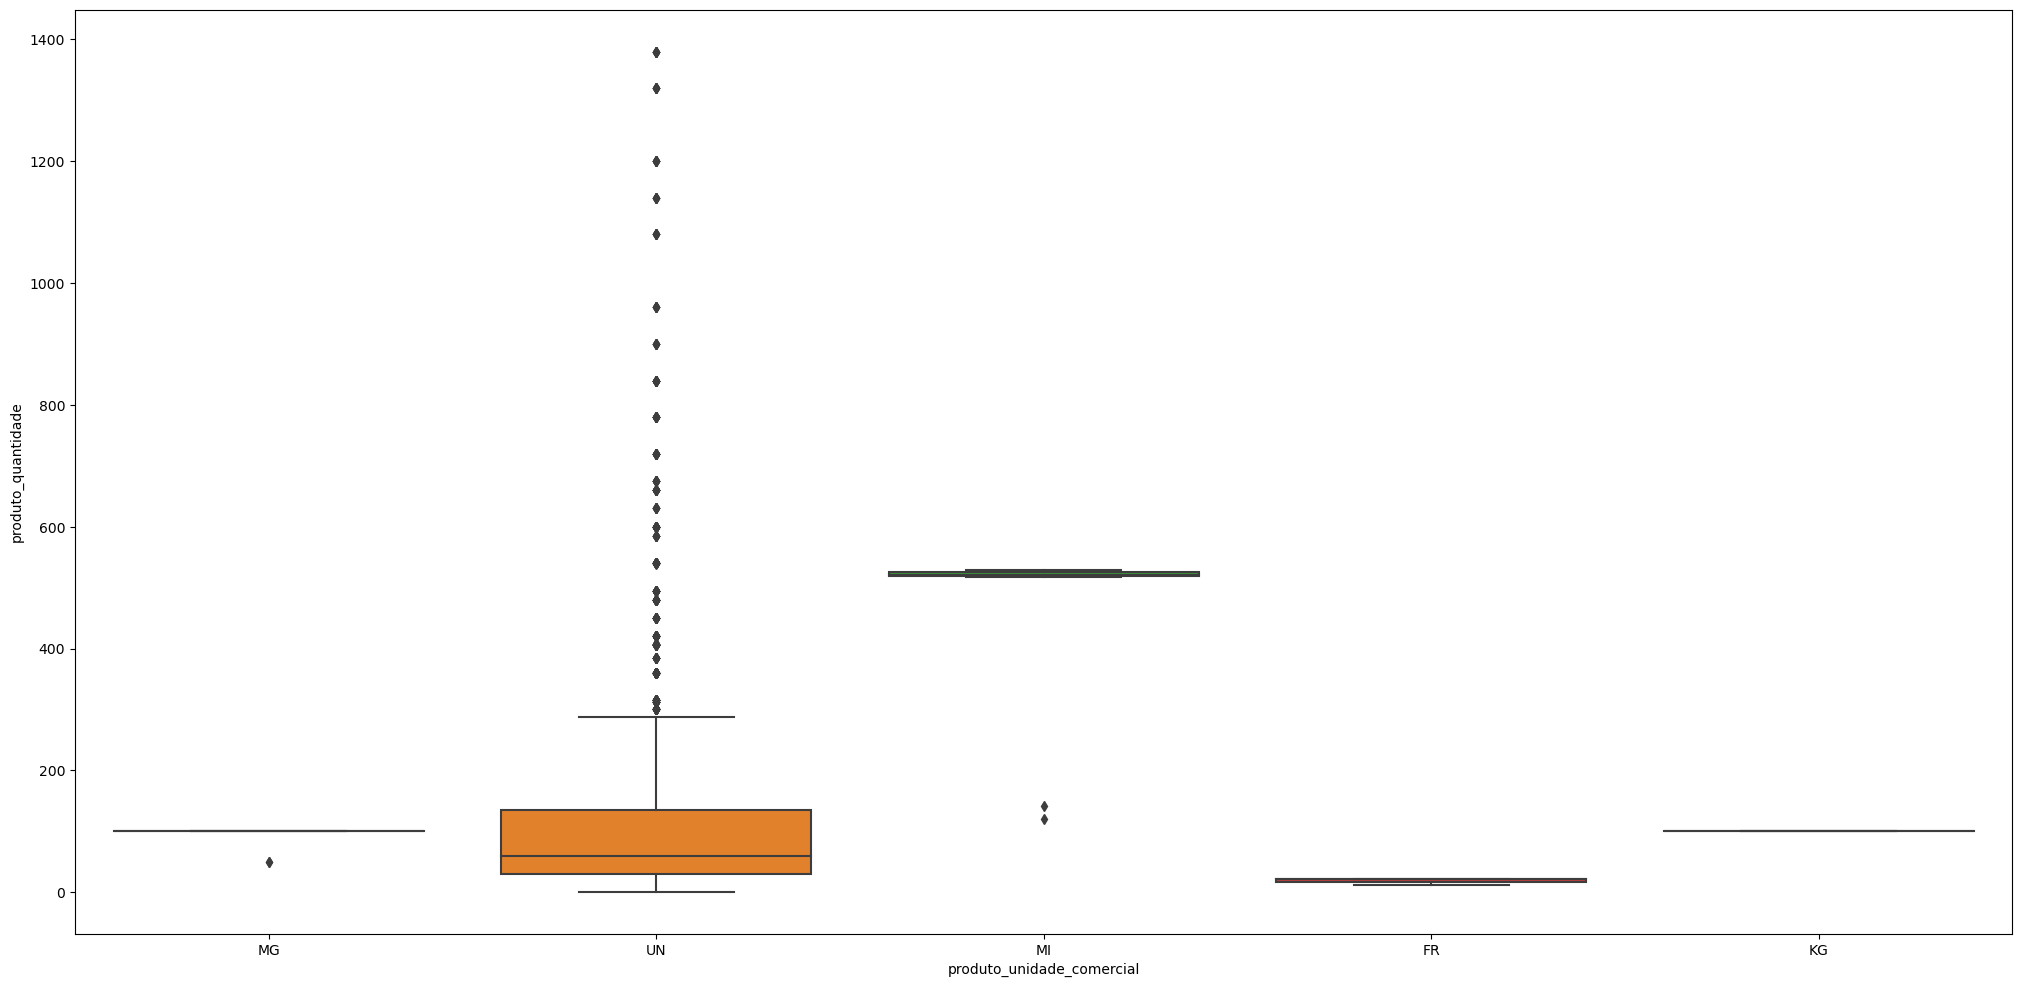

In [206]:
sns.boxplot (x = 'produto_unidade_comercial', y = 'produto_quantidade', data = df1);

**1.** Foi utilizado o algoritmo KNN para identificar valores muito distantes. Valores de Outliers identificados pelo KNN foram removidos.

## 2.0. PASSO 02 - FEATURE ENGINEERING

In [207]:
df2 = df1.copy()

### 2.1. Criação de Hipóteses

**1.** A demanda aumenta no começo do ano.

**2.** Há um aumento de demanda com o passar dos anos.

### 2.2. Feature Engineering

In [208]:
# year
df2['year'] = df2['nota_data_emissao'].dt.year

# month
df2['month'] = df2['nota_data_emissao'].dt.month

# day
df2['day'] = df2['nota_data_emissao'].dt.day

# week of year
df2['week_of_year'] = df2['nota_data_emissao'].dt.isocalendar().week.astype(np.int64)

num_attributes = df2.select_dtypes (include = ['float64', 'int64'])

## 3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS

In [209]:
df3 = df2.copy()

### 3.1. Filtragem de Linhas

In [210]:
df3 = df3[(df3['produto_quantidade'] != 0)]

## 4.0. PASSO 04 - ANÁLISE EXPLORATÓRIA DE DADOS

In [211]:
df4 = df3.copy()

### 4.1. Análise Univariada

#### 4.1.1. Variável Resposta

<AxesSubplot: xlabel='produto_quantidade', ylabel='Density'>

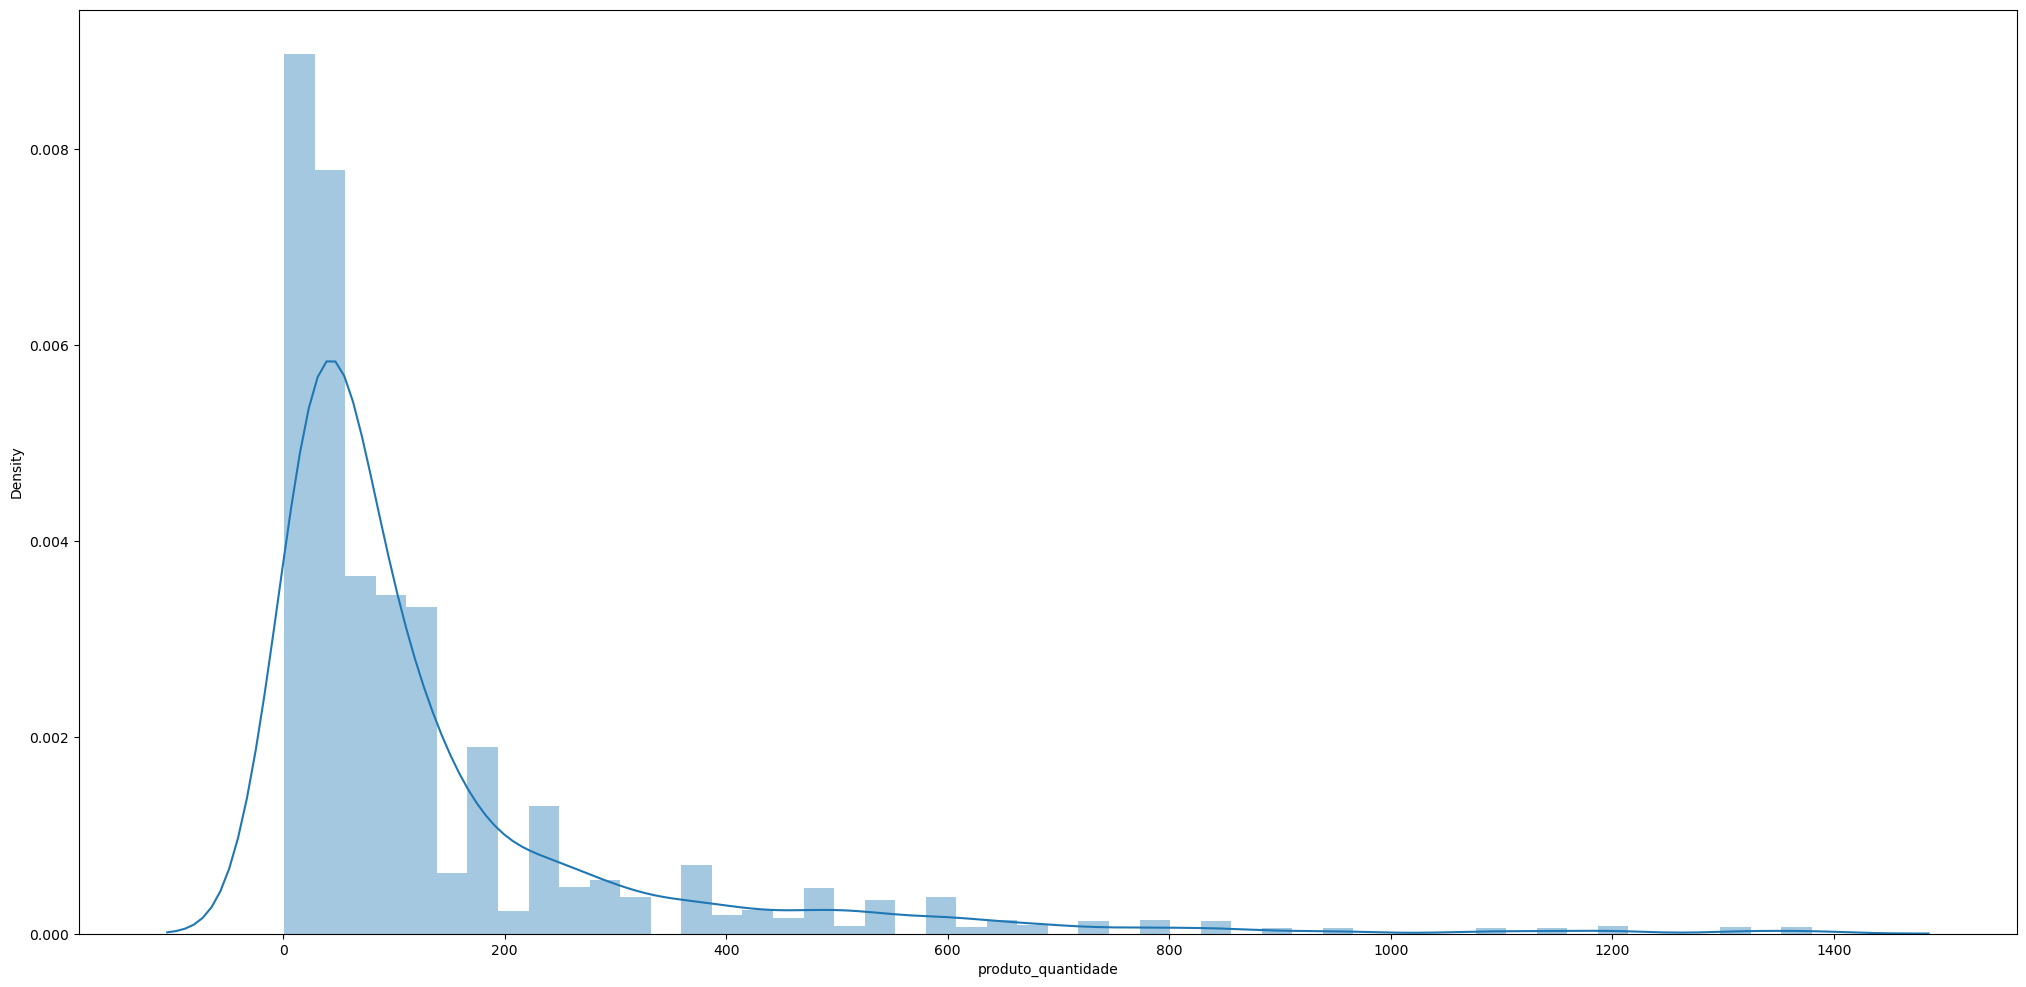

In [212]:
sns.distplot(df4['produto_quantidade'], kde = True)

**1.** Transformação Logarítmica pode ser uma opção viável para preparação.

#### 4.1.2. Variáveis Numéricas

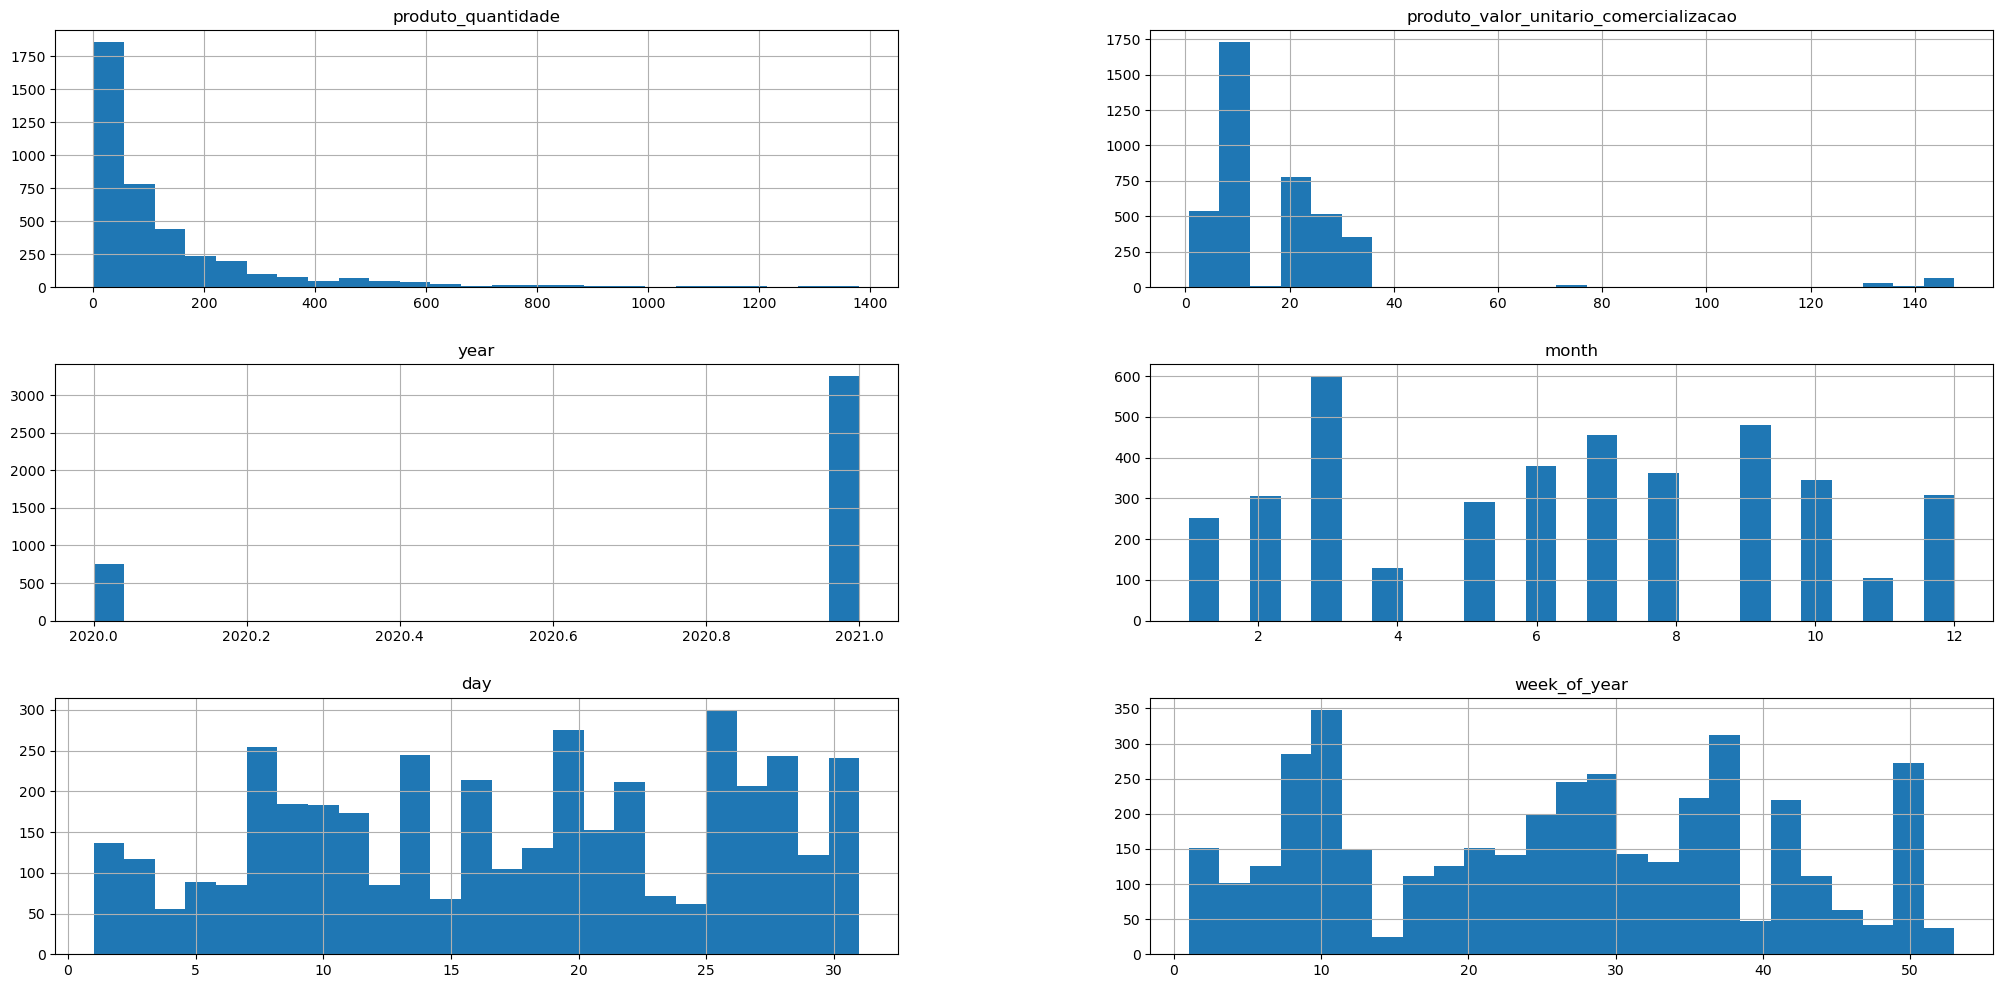

In [213]:
num_attributes.hist (bins = 25);

#### 4.1.3. Variáveis Categóricas

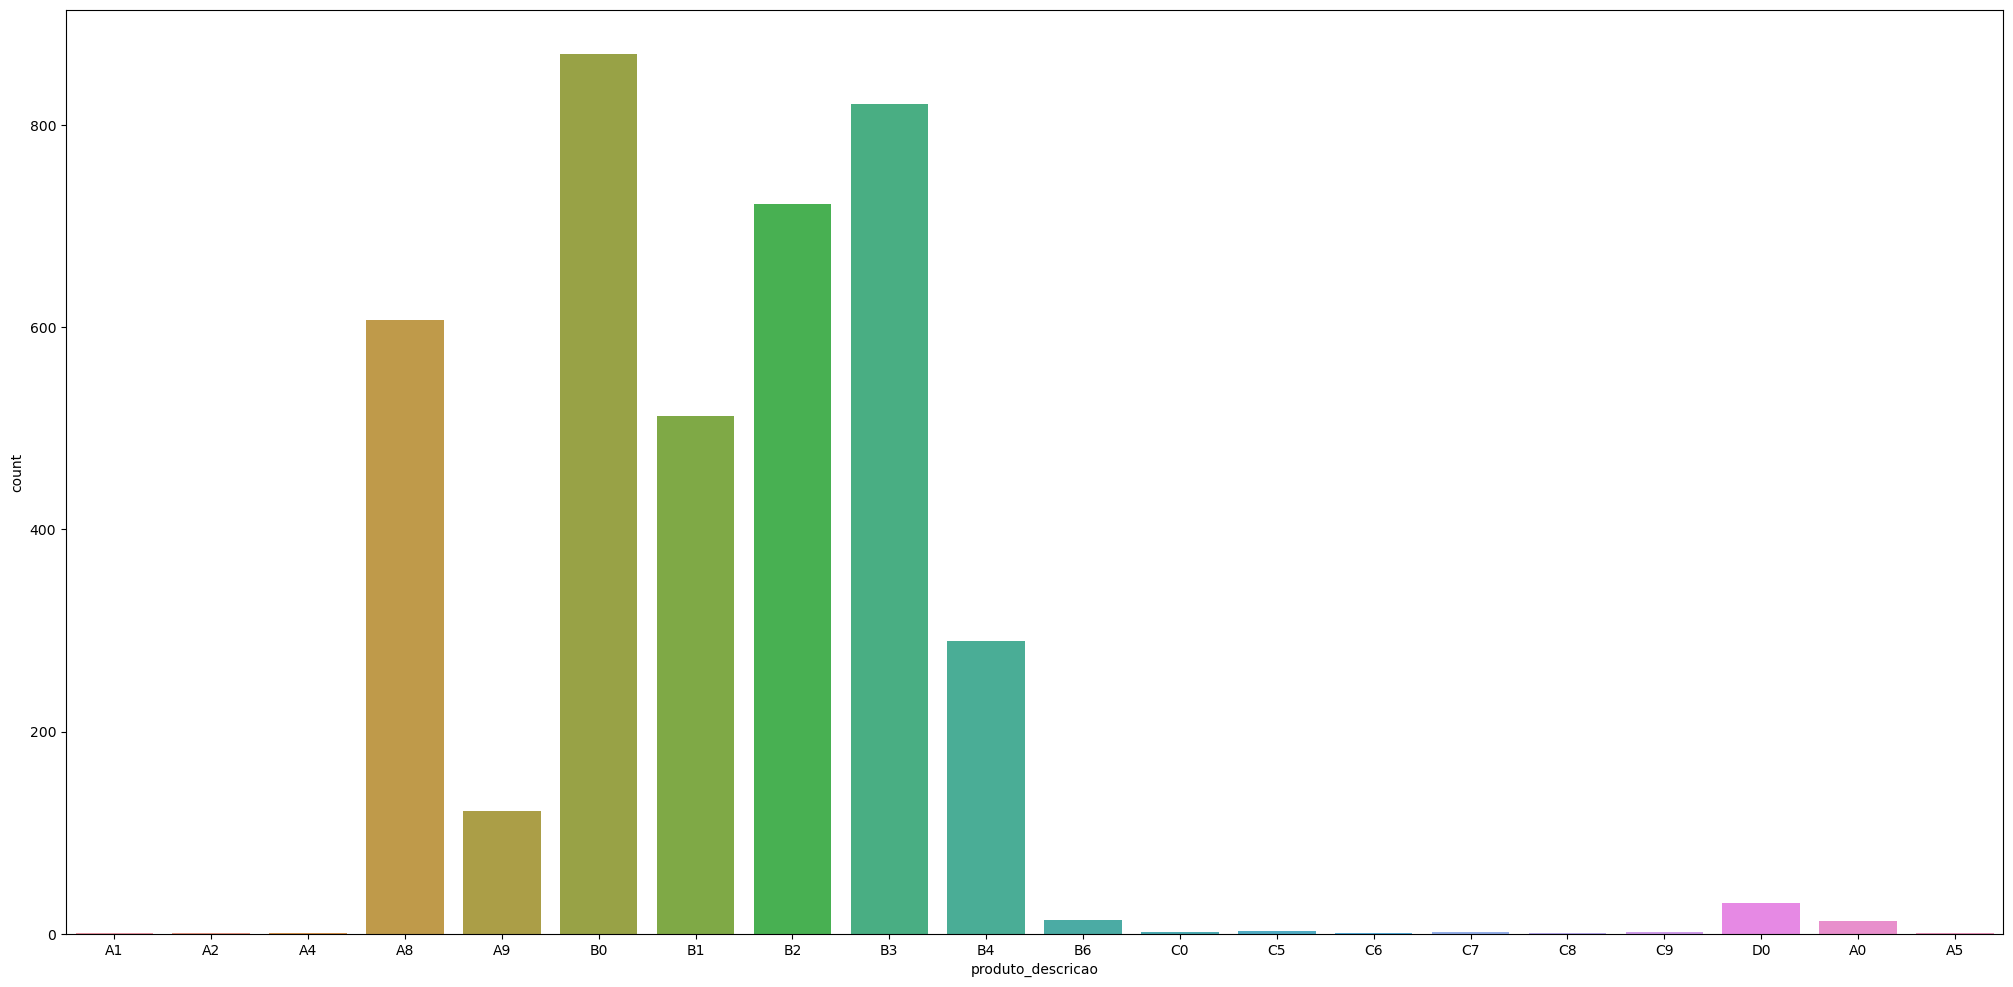

In [214]:
sns.countplot( x = 'produto_descricao', data = df4);

**1.** Muitos produtos com poucas compras realizadas.

### 4.2. Análise Bivariada

#### H1. A demanda aumenta no começo do ano.

**FALSO** - No período de Outubro até Janeiro as demandas são mais baixas

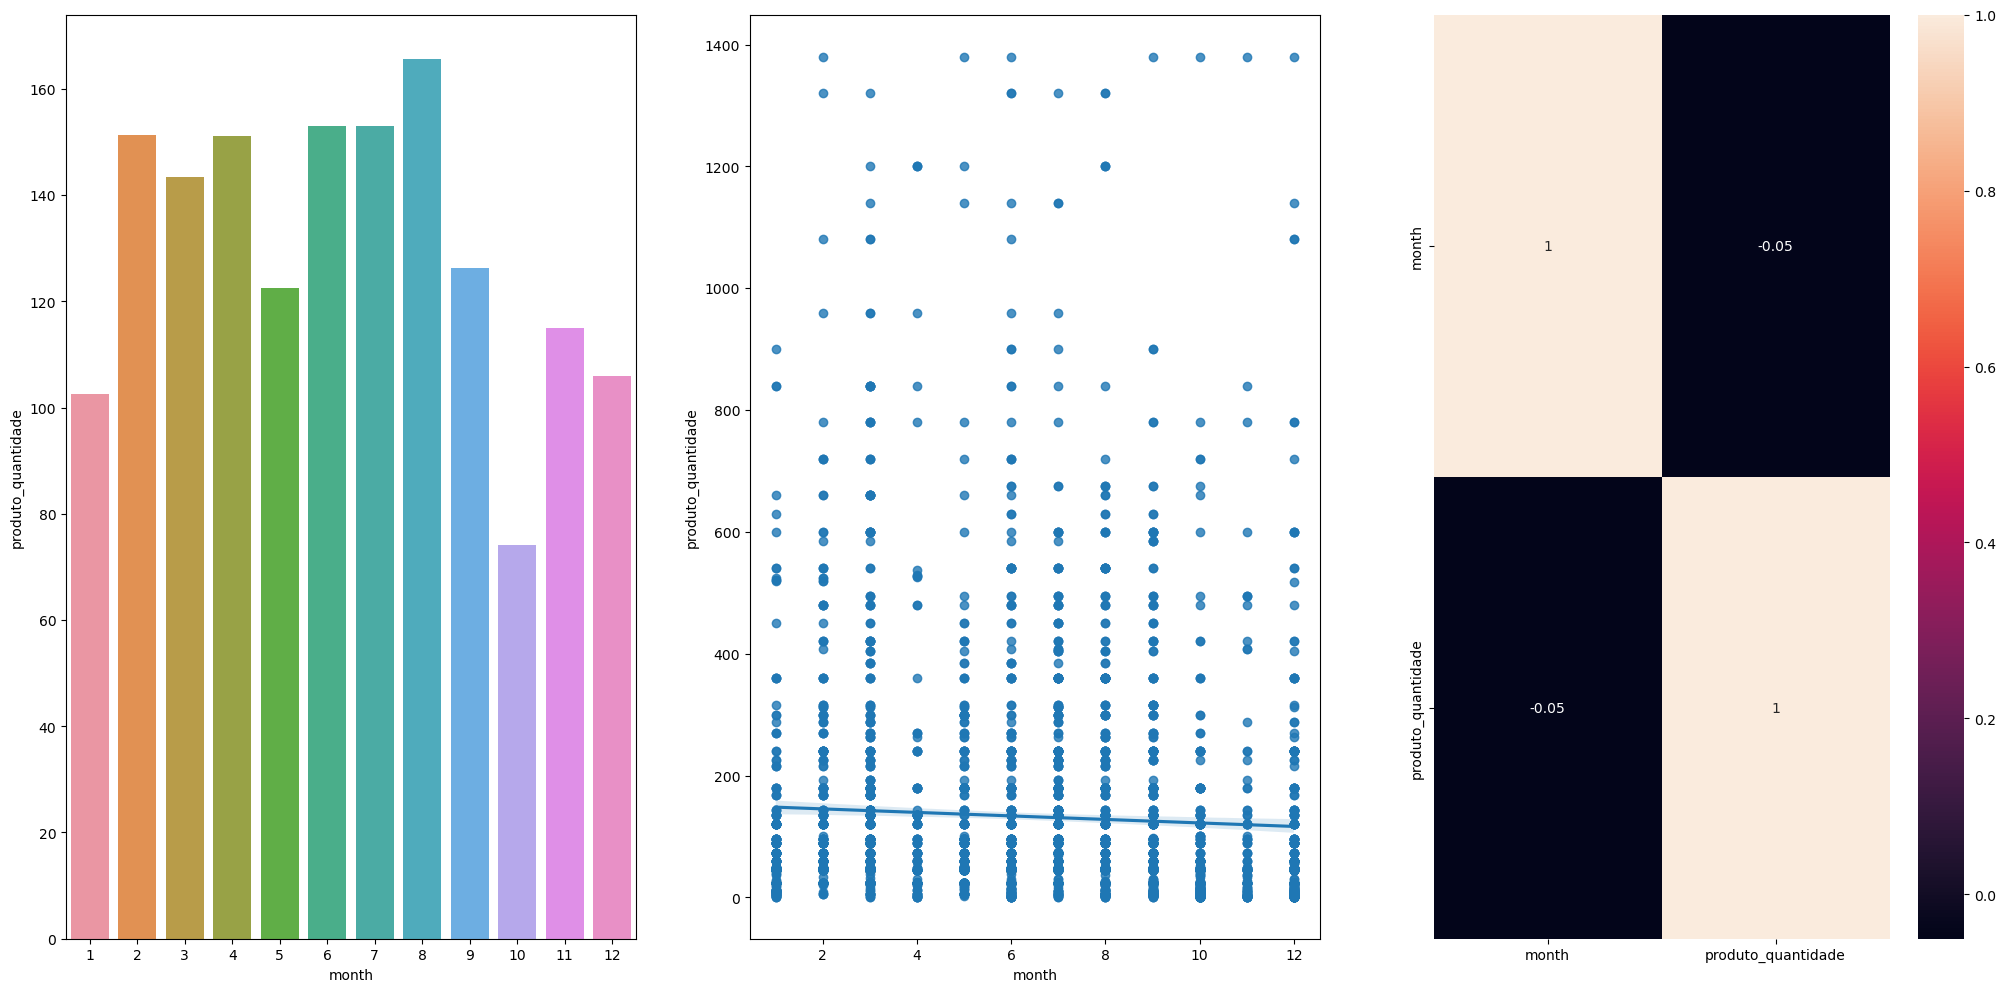

In [215]:
aux1 = df4[['month', 'produto_quantidade']].groupby('month').mean().reset_index()

plt.subplot (1, 3, 1)
sns.barplot (x = 'month', y = 'produto_quantidade', data = aux1);

plt.subplot (1, 3, 2)
sns.regplot (x = 'month', y = 'produto_quantidade', data = df4);

plt.subplot (1, 3, 3)
sns.heatmap (df4[['month', 'produto_quantidade']].corr (method = 'pearson'), annot = True);

#### H2. Há um aumento de demanda com o passar dos anos.

**VERDADEIRO**

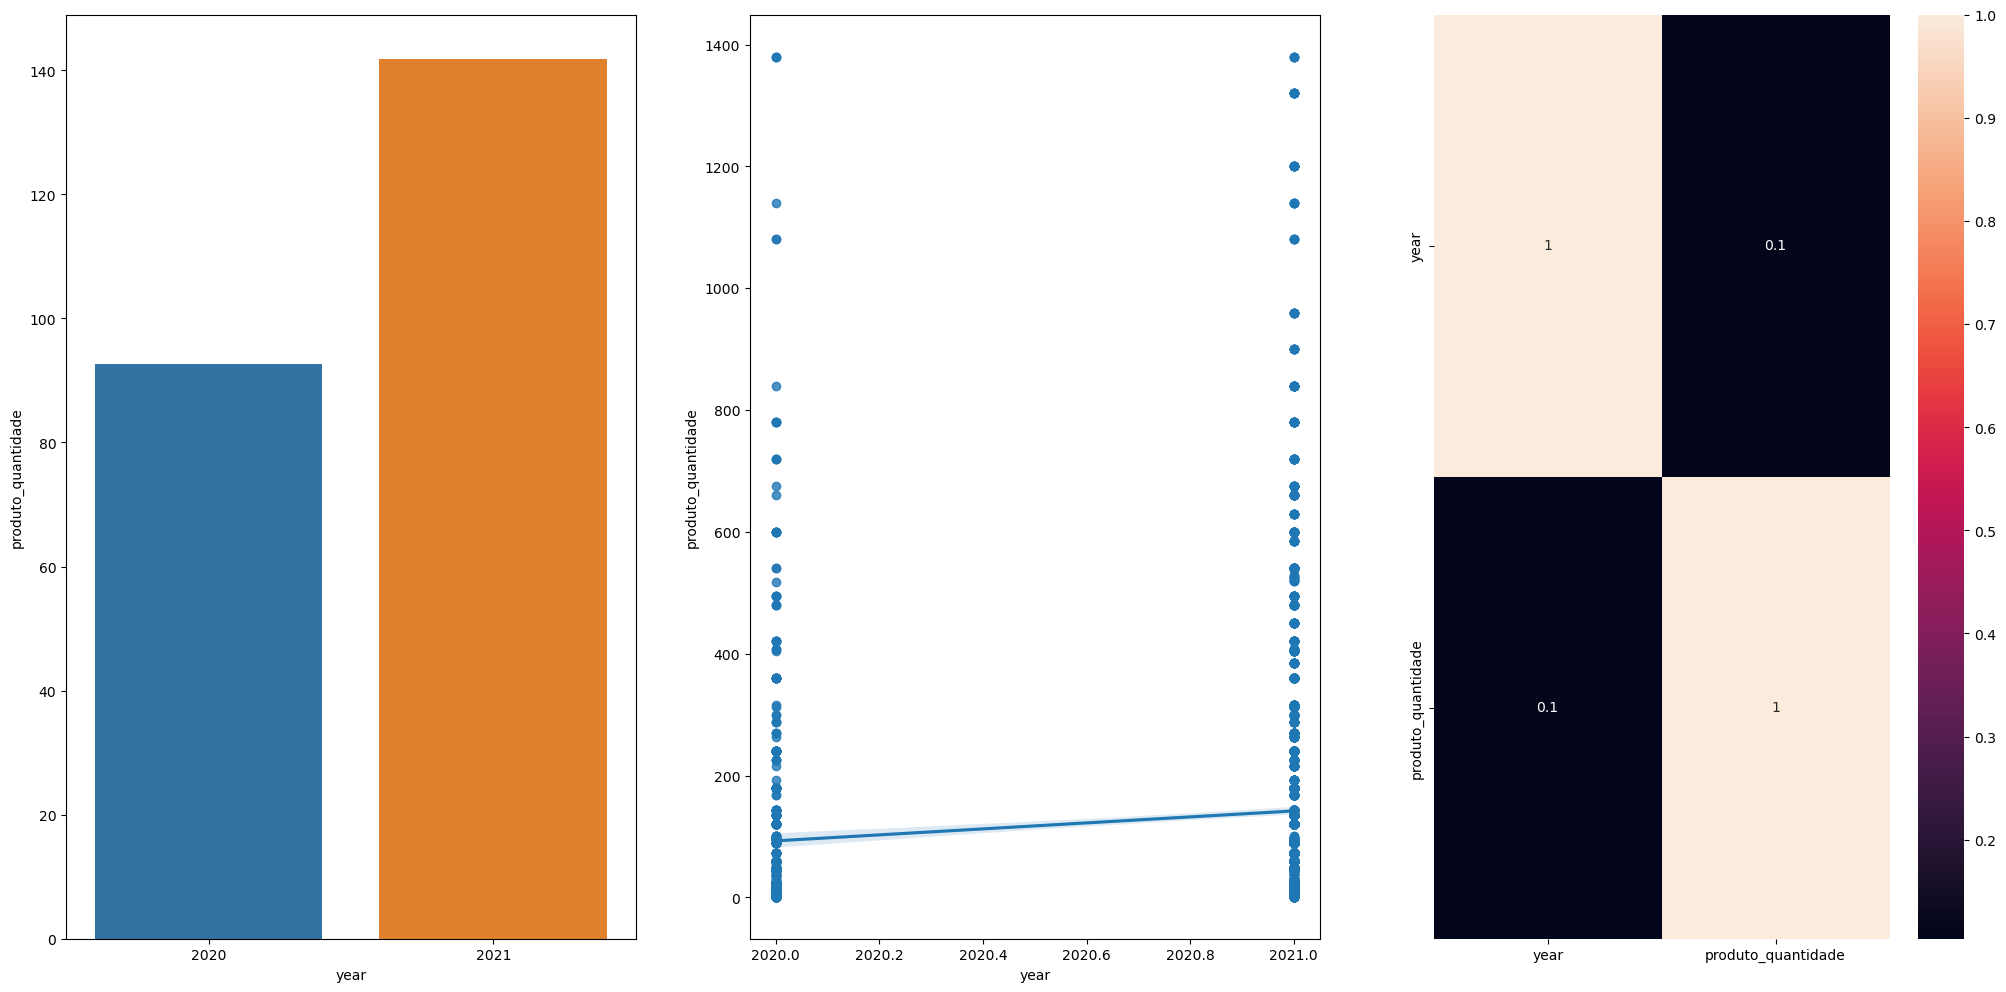

In [216]:
aux1 = df4[['year', 'produto_quantidade']].groupby('year').mean().reset_index()
plt.subplot (1, 3, 1)
sns.barplot (x = 'year', y = 'produto_quantidade', data = aux1);

plt.subplot (1, 3, 2)
sns.regplot (x = 'year', y = 'produto_quantidade', data = df4);

plt.subplot (1, 3, 3)
sns.heatmap (df4[['year', 'produto_quantidade']].corr (method = 'pearson'), annot = True);

### 4.3. Análise Multivariada

#### 4.3.1. Atributos Numéricos

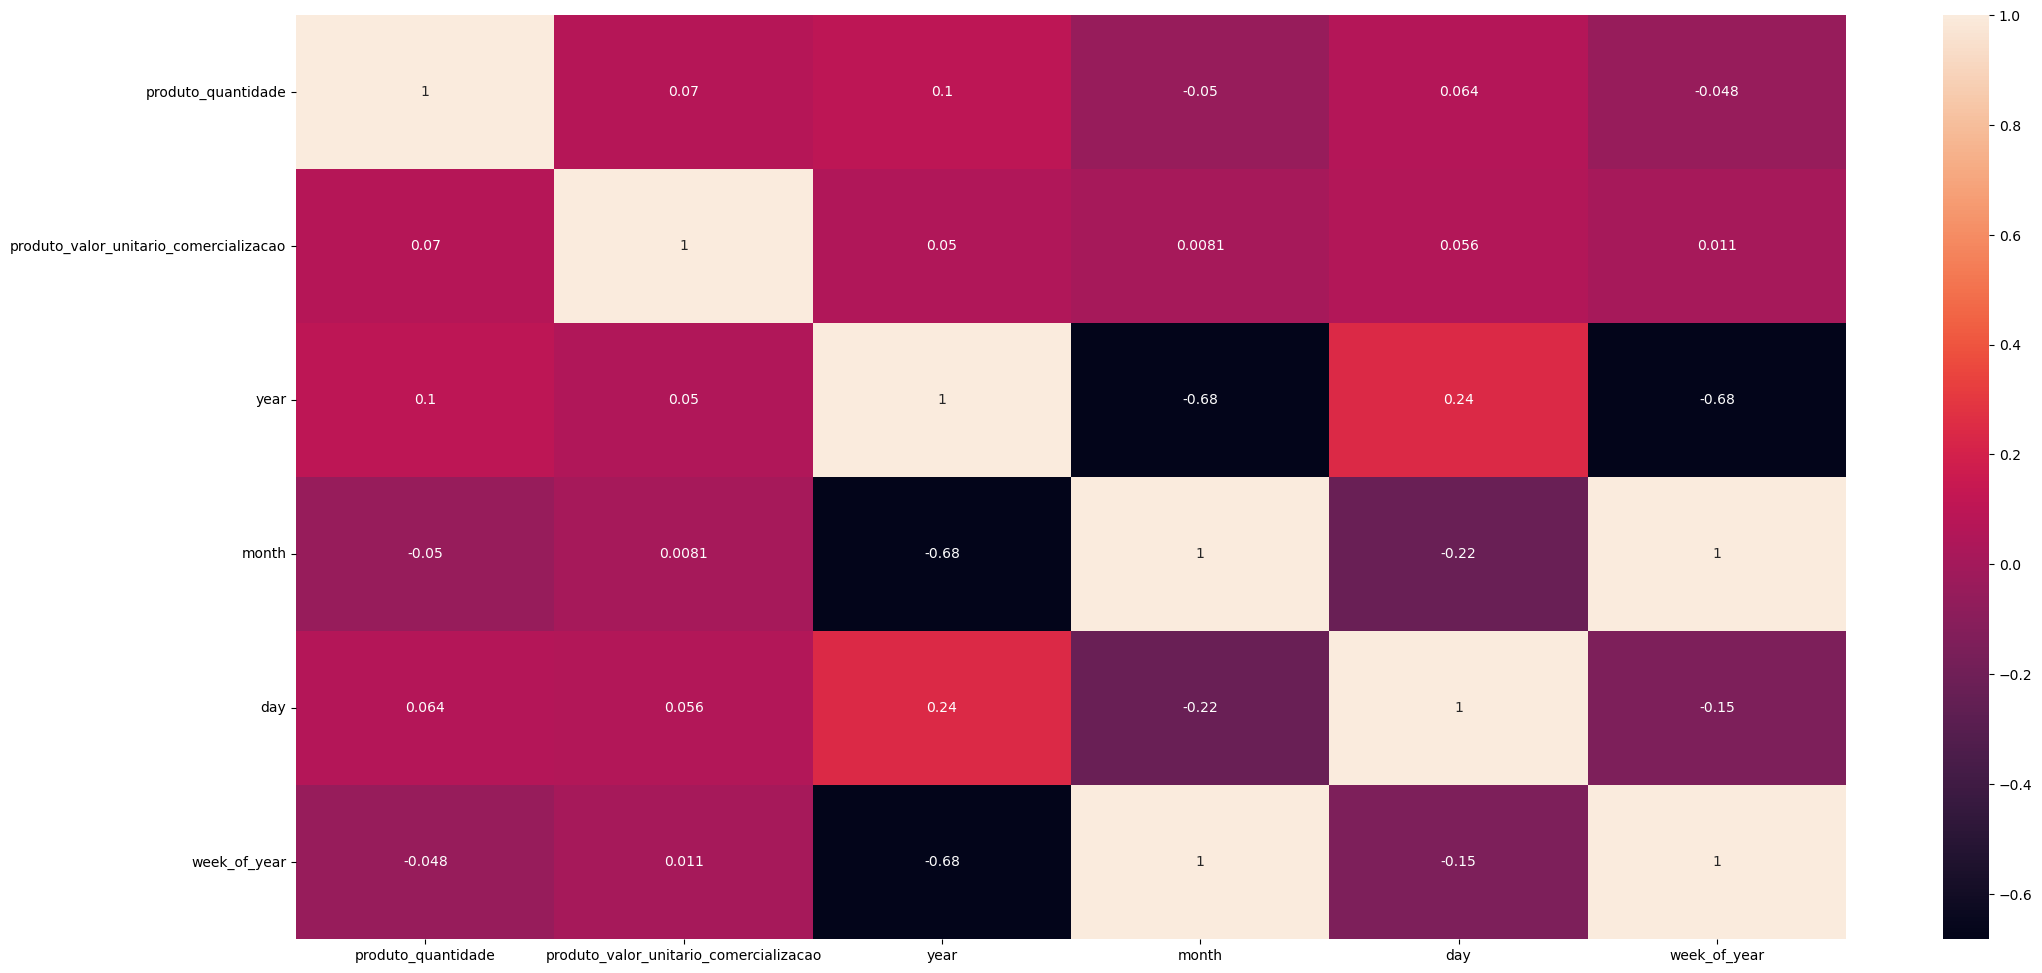

In [217]:
correlation = num_attributes.corr (method = 'pearson')
sns.heatmap (correlation, annot = True);

**1.** Principais correlações entre atributos temporais

#### 4.3.2. Atributos Categóricos

In [218]:
a = df4.select_dtypes (include = 'object')
a1 = cramers_v (a['produto_descricao'], a['produto_descricao'])
a2 = cramers_v (a['produto_descricao'], a['produto_unidade_comercial'])

a3 = cramers_v (a['produto_unidade_comercial'], a['produto_unidade_comercial'])
a4 = cramers_v (a['produto_unidade_comercial'], a['produto_descricao'])

d = pd.DataFrame ({'produto_descricao': [a1, a2], 'produto_unidade_comercial': [a3, a4]})
d = d.set_index (d.columns)
d

,produto_descricao,produto_unidade_comercial
produto_descricao,1.00,1.00
produto_unidade_comercial,1.00,1.00


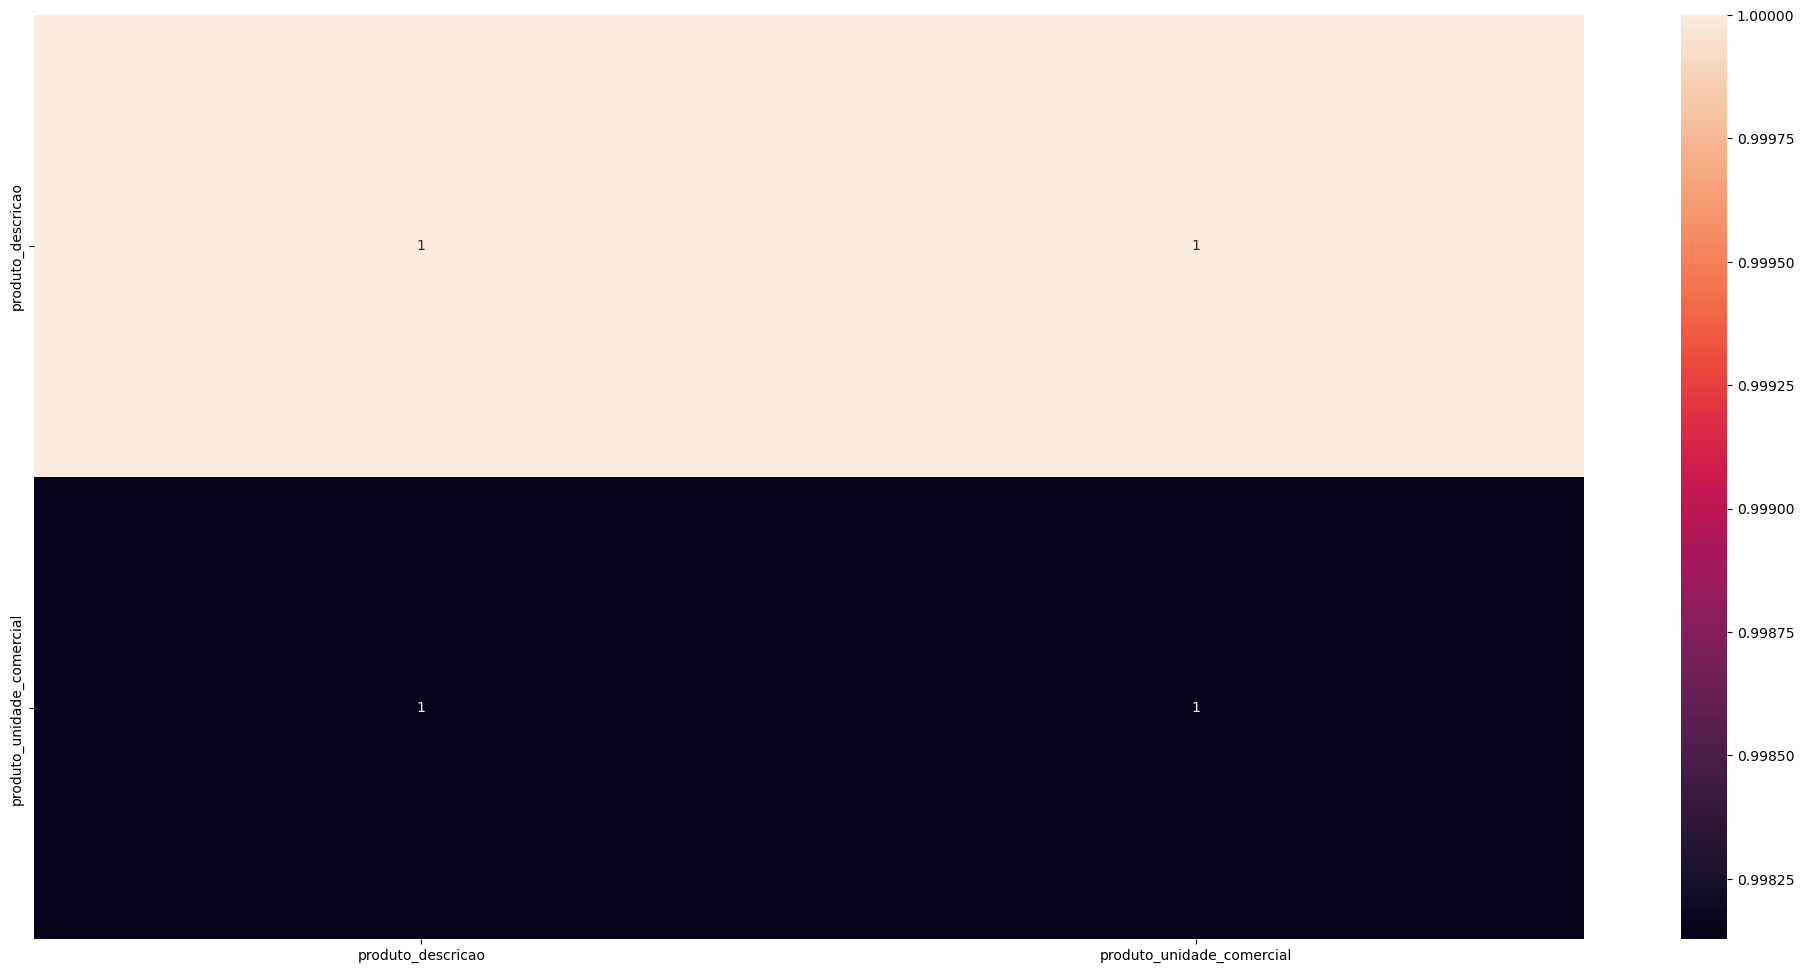

In [219]:
sns.heatmap (d, annot = True);

**1.** A correção é direta, já que cada tipo de produto está vinculado a uma unidade comercial.

## 5.0. PASSO 05 - PREPARAÇÃO DOS DADOS

In [220]:
df5 = df4.copy()

### 5.1. Rescaling

In [221]:
mms = MinMaxScaler()

In [222]:
# preço
df5['produto_valor_unitario_comercializacao'] = mms.fit_transform (df5[['produto_valor_unitario_comercializacao']].values)
pickle.dump(mms, open('parameter/produto_valor_unitario_comercializacao_scaler.pkl', 'wb'))

In [223]:
# year
df5['year'] = mms.fit_transform (df5[['year']].values)
pickle.dump(mms, open('parameter/year_scaler.pkl', 'wb'))

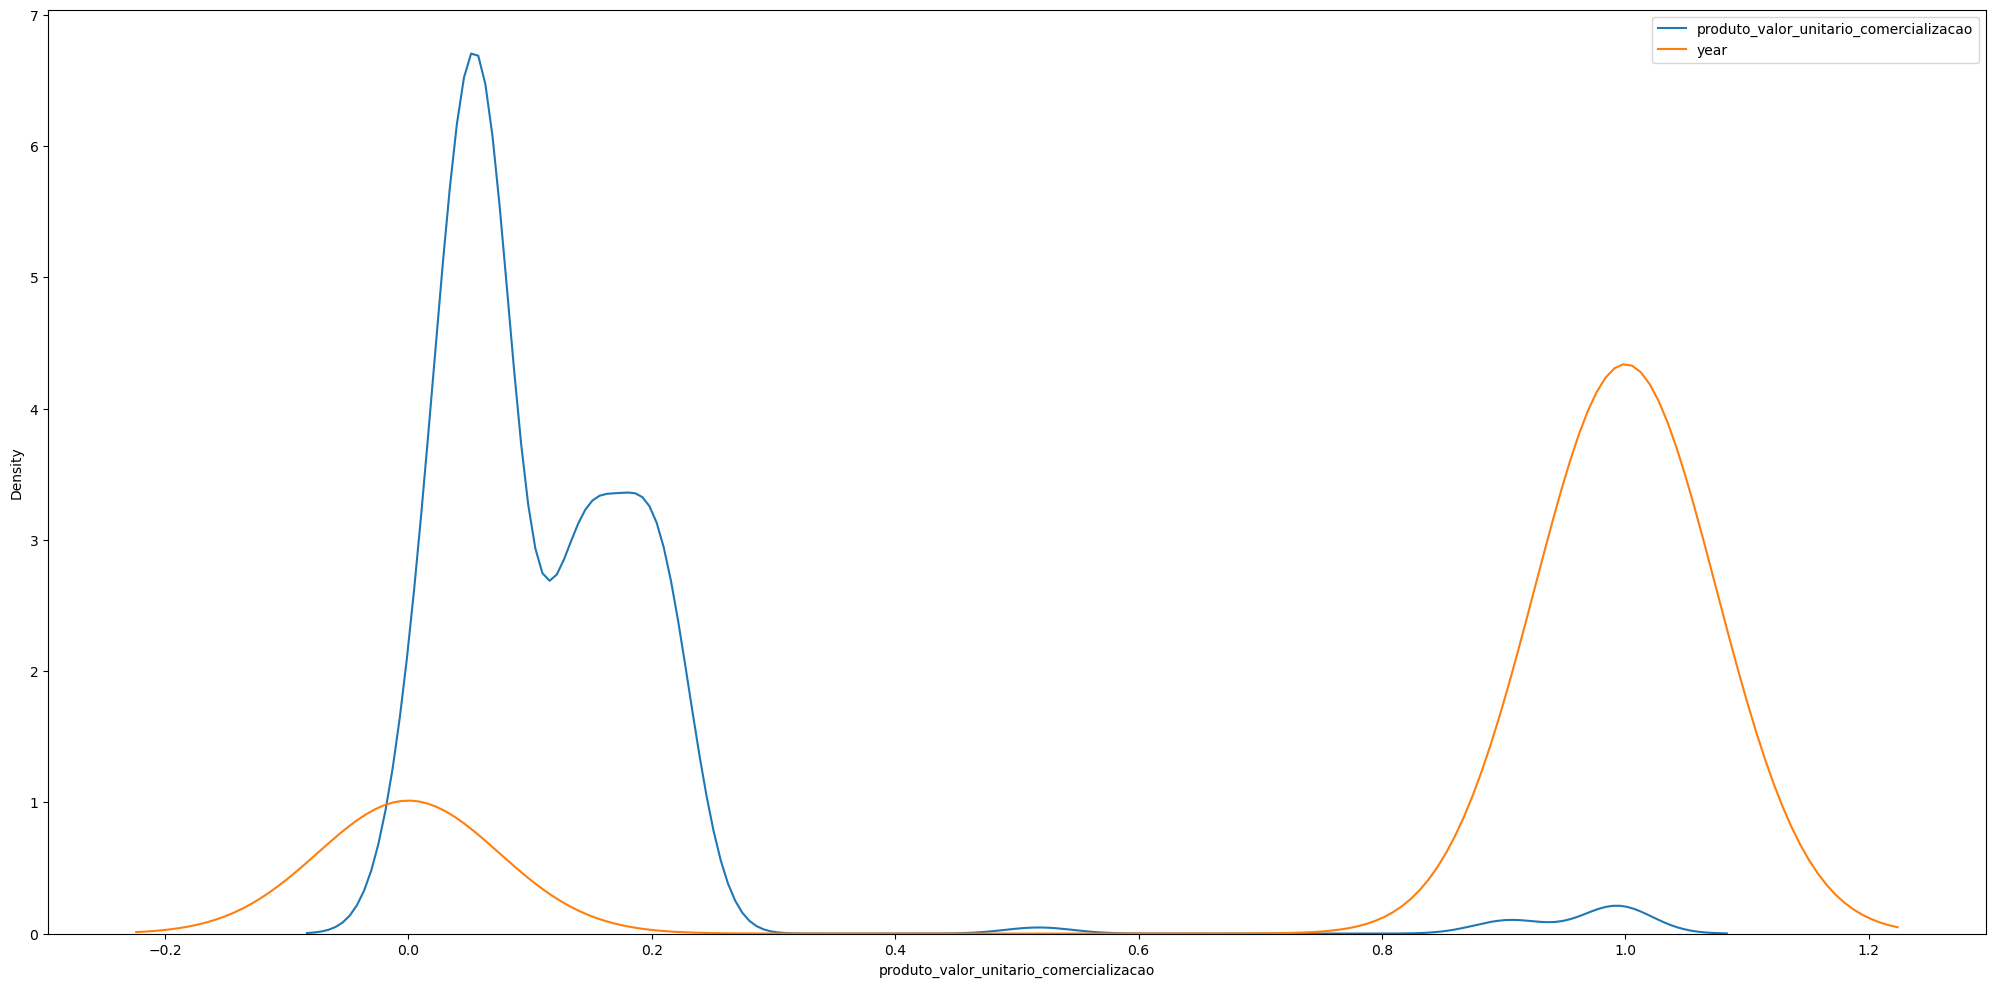

In [224]:
sns.kdeplot(df5['produto_valor_unitario_comercializacao'], label = 'produto_valor_unitario_comercializacao');
sns.kdeplot(df5['year'], label = 'year');
plt.legend(loc='upper right');

### 5.2. Transformação

#### 5.2.1. Encoding

In [276]:
# produto_descricao
te = MEstimateEncoder()
te.fit(df5['produto_descricao'], y = df5['produto_quantidade'])
df5['num_produto_descricao'] = te.transform(df5['produto_descricao'])
pickle.dump(te, open('parameter/num_produto_descricao_1_scaler.pkl', 'wb'))

# produto_unidade_comercial
te.fit(df5['produto_unidade_comercial'], df5['produto_quantidade'])
df5['num_produto_unidade_comercial'] = te.transform(df5['produto_unidade_comercial'])
pickle.dump(te, open('parameter/num_produto_unidade_comercial_1_scaler.pkl', 'wb'))

In [247]:
# produto_descricao
df5['num_produto_descricao'] = mms.fit_transform (df5[['num_produto_descricao']].values)
pickle.dump(mms, open('parameter/num_produto_descricao_2_scaler.pkl', 'wb'))

# num_produto_unidade_comercial
df5['num_produto_unidade_comercial'] = mms.fit_transform (df5[['num_produto_unidade_comercial']].values)
pickle.dump(mms, open('parameter/num_produto_unidade_comercial_2_scaler.pkl', 'wb'))

**1.** Foi escolhido o TargetEncoder para ambas as variáveis numéricas. O OneHotEncoder foi desconsiderado devido a quantidade de colunas que seriam adicionadas ao dataframe.

#### 5.2.2. Transformação de Natureza

In [227]:
# month
df5['month_sin'] = df5['month'].apply (lambda x: np.sin (x*2*np.pi/12))
df5['month_cos'] = df5['month'].apply (lambda x: np.cos (x*2*np.pi/12))

# day
df5['day_sin'] = df5['day'].apply (lambda x: np.sin (x*2*np.pi/30))
df5['day_cos'] = df5['day'].apply (lambda x: np.cos (x*2*np.pi/30))

# week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply (lambda x: np.sin (x*2*np.pi/52))
df5['week_of_year_cos'] = df5['week_of_year'].apply (lambda x: np.cos (x*2*np.pi/52))

**1.**. Foi escolhido a transformação sen/cos para *month, day e week_of_year*, por possuírem natureza cíclica.

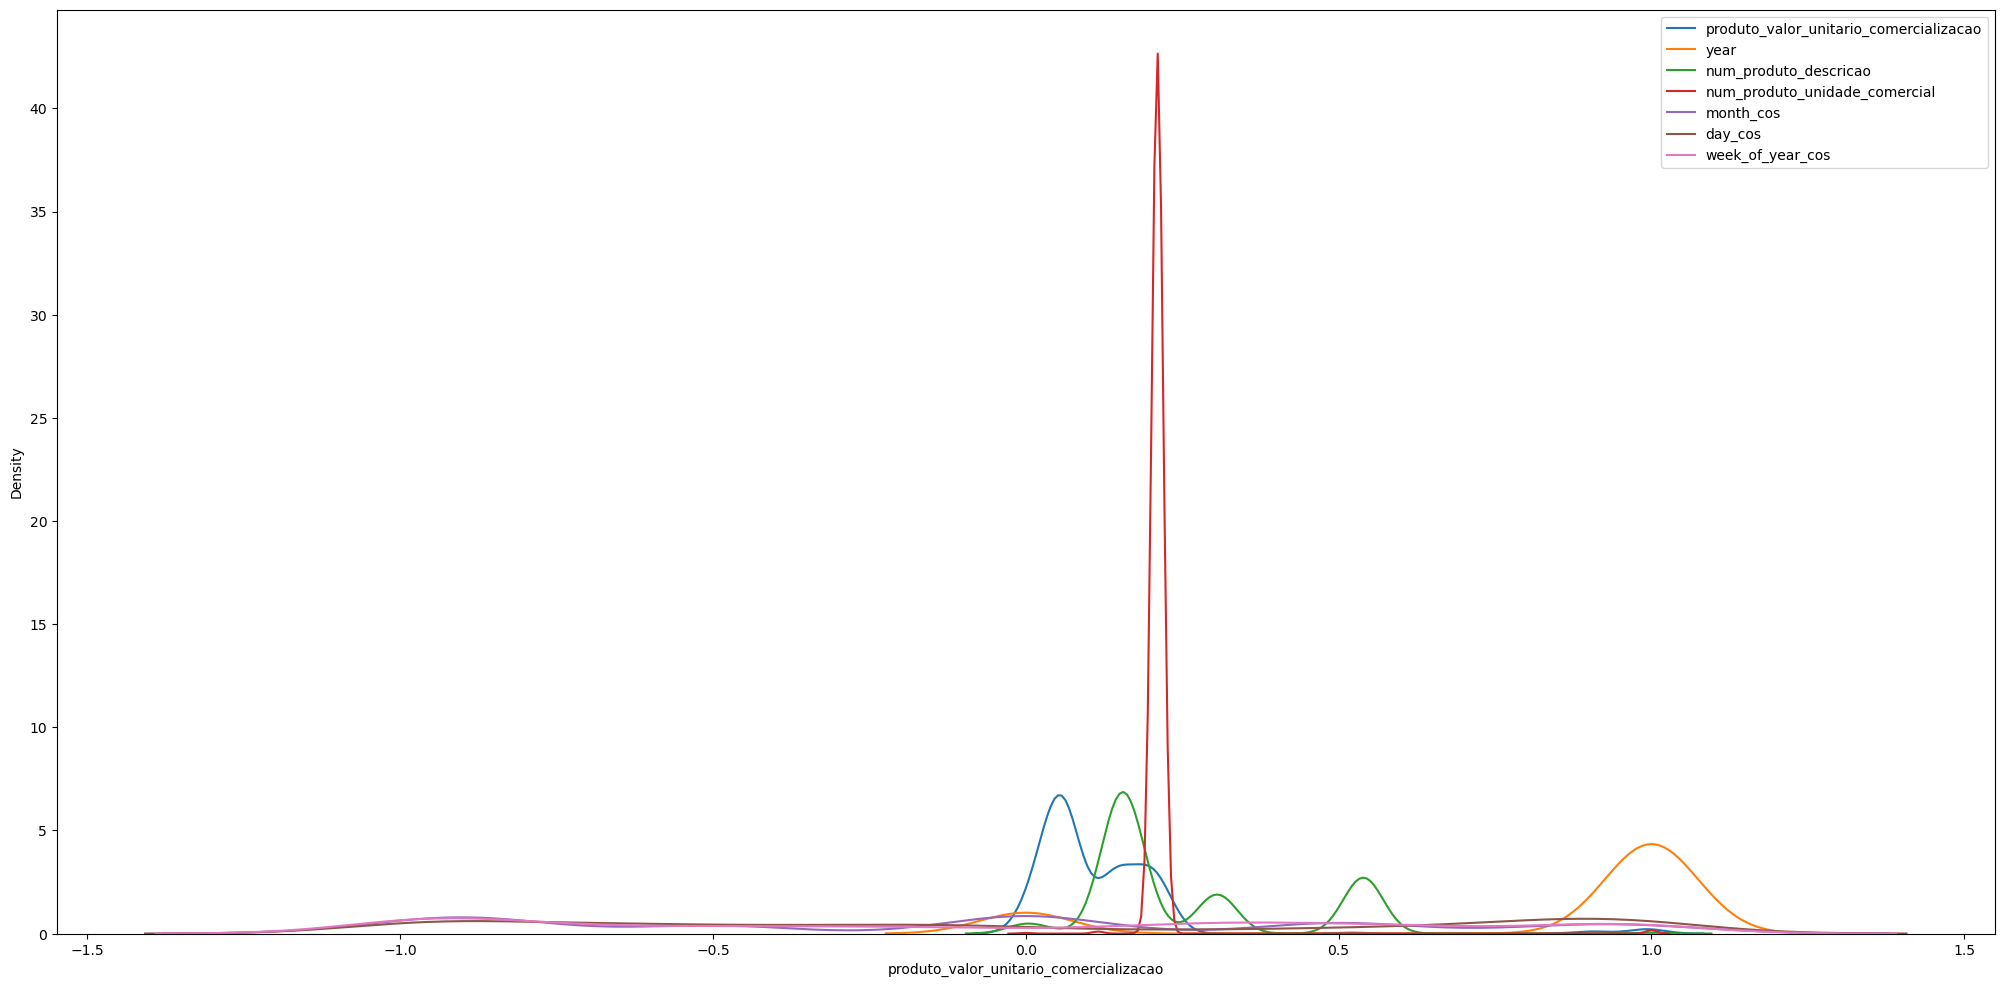

In [228]:
sns.kdeplot(df5['produto_valor_unitario_comercializacao'], label = 'produto_valor_unitario_comercializacao')
sns.kdeplot(df5['year'], label = 'year')
sns.kdeplot(df5['num_produto_descricao'], label = 'num_produto_descricao')
sns.kdeplot(df5['num_produto_unidade_comercial'], label = 'num_produto_unidade_comercial')
sns.kdeplot(df5['month_cos'], label = 'month_cos')
sns.kdeplot(df5['day_cos'], label = 'day_cos');
sns.kdeplot(df5['week_of_year_cos'], label = 'week_of_year_cos');
plt.legend(loc='upper right'); 

#### 5.2.3. Transformação da Variável Resposta

In [229]:
# produto_quantidade
df5['produto_quantidade'] = np.log1p(df5['produto_quantidade'])

<AxesSubplot: xlabel='produto_quantidade', ylabel='Count'>

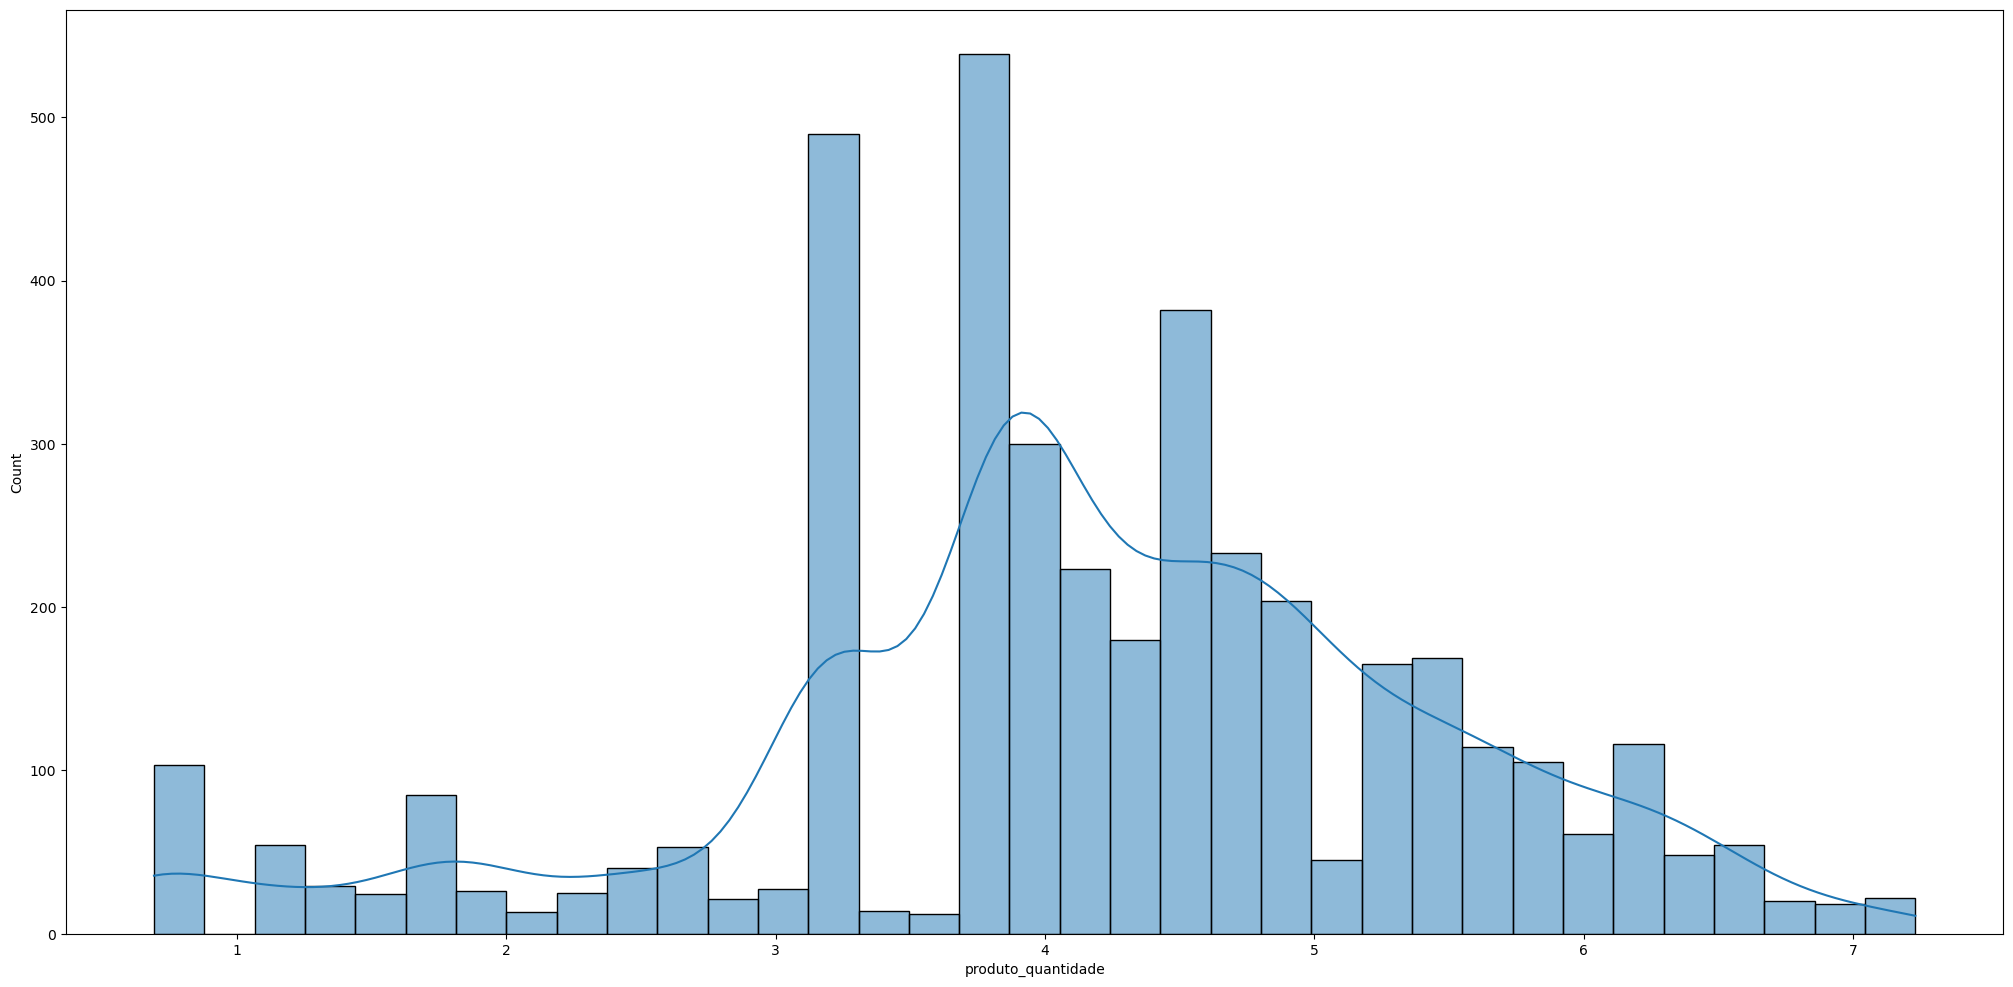

In [230]:
sns.histplot(df5['produto_quantidade'], kde=True)

### 5.1. Separação dos Dados

In [231]:
df5[['produto_descricao', 'nota_data_emissao']].groupby('produto_descricao').max().reset_index()['nota_data_emissao'][0] - datetime.timedelta (days = 4*7)

Timestamp('2020-11-04 00:00:00')

**1.** Separação dos produtos por tipo. Intervalo de tempo utilizado foi semanas.

In [232]:
# train dataset
x_train = df5[df5['nota_data_emissao'] < '2021-09-02']
y_train = x_train['produto_quantidade']

# test dataset
x_test = df5[df5['nota_data_emissao'] >= '2021-09-02']
y_test = x_test['produto_quantidade']

**1.** Foi escolhido a transformação boxcox para normalizar a coluna de preços. Ela apresentou um resultado melhor que a transformação logarítmica

## 6.0. PASSO 06 - SELEÇÃO DE FEATURES

In [233]:
cols_selected = ['produto_valor_unitario_comercializacao',
                 'year',
                 'num_produto_descricao',
                 'num_produto_unidade_comercial',
                 'month_sin',
                 'month_cos',
                 'day_sin',
                 'day_cos',
                 'week_of_year_sin',
                 'week_of_year_cos']
                 
# columns to add
feat_to_add = ['nota_data_emissao', 'produto_quantidade']

cols_selected_full = cols_selected.copy()
cols_selected_full.extend(feat_to_add)

## 7.0. PASSO 07 - MACHINE LEARNING MODELING

In [234]:
X_train = x_train[cols_selected]
X_test = x_test[cols_selected]

# Time series data preparation
x_training = x_train[cols_selected_full]

### 7.1. Average Model

In [235]:
aux1 = x_test.copy()
aux1['produto_quantidade'] = y_test.copy()

# prediction
aux2 = aux1[['produto_descricao', 'produto_quantidade']].groupby('produto_descricao').mean().reset_index().rename(columns = {'produto_quantidade': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='produto_descricao')
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result


,Model Name,MAE,MAPE,RMSE
0,Average Model,83.04,1.27,153.71


### 7.2. Linear Regression Model

In [236]:
# model
lr = LinearRegression().fit(X_train, y_train)

# prediction
yhat_lr = lr.predict(X_test)

# performance
lr_result = ml_error ('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,86.52,1.38,156.59


#### 7.2.1. Linear Regression Model - Cross validation

In [237]:
lr_result_cv = cross_validation(x_training, 10, 'Linear Regression', lr)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,29093895.36 +/- 87281386.63,681059.42 +/- 2043174.06,215420722.03 +/- 646261602.43


### 7.3. Random Forest Regressor

In [238]:
# model
rf = RandomForestRegressor(n_estimators = 100, n_jobs = -1, random_state = 10).fit(X_train, y_train)

# prediction
yhat_rf = rf.predict(X_test)

# performance
rf_result = ml_error ('Random Forest Regressor', np.expm1 (y_test), np.expm1 (yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,86.34,1.39,148.47


#### 7.4.1. Random Forest Regressor - Cross validation

In [239]:
rf_result_cv = cross_validation(x_training, 10, 'Random Forest', rf)
rf_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest,103.98 +/- 21.0,2.01 +/- 1.44,185.54 +/- 40.49


### 7.4. XGBoost Regressor

In [240]:
# model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                              n_estimators=100,
                              eta=0.01,
                              max_depth=10,
                              subsample=0.7,
                              colsample_bytree=0.9).fit(X_train, y_train)
# prediction
yhat_xgb = model_xgb.predict(X_test)

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,112.62,0.83,193.67


#### 7.5.1. XGBoost Regressor - Cross Validation

In [241]:
xgb_result_cv = cross_validation(x_training, 10, 'XGBoost Regressor', model_xgb)
xgb_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,121.17 +/- 21.97,0.85 +/- 0.1,216.47 +/- 41.65


### 7.6. Comparação de Performance Entre Modelos

In [242]:
modelling_result_cv = pd.concat([lr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result_cv.sort_values('RMSE CV')

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest,103.98 +/- 21.0,2.01 +/- 1.44,185.54 +/- 40.49
0,Linear Regression,29093895.36 +/- 87281386.63,681059.42 +/- 2043174.06,215420722.03 +/- 646261602.43
0,XGBoost Regressor,121.17 +/- 21.97,0.85 +/- 0.1,216.47 +/- 41.65


**1.** O modelo escolhido para produção será o XGBoost.

### 8.2. Modelo Final

In [243]:
# param tuned
param_tuned = {'n_estimators': 100,
               'eta': 0.01,
               'max_depth': 10,
               'subsample': 0.7,
               'colsample_bytree': 0.9,
               'min_child_weight': 5}

# model
model_xgb_tuned = xgb.XGBRegressor(objective='reg:squarederror',
                                   n_estimators=param_tuned['n_estimators'],
                                   eta=param_tuned['eta'],
                                   max_depth=param_tuned['max_depth'],
                                   subsample=param_tuned['subsample'],
                                   colsample_bytree=param_tuned['colsample_bytree'],
                                   min_child_weight=param_tuned['min_child_weight']).fit(X_train, y_train)

xgb_result_tuned = cross_validation(x_training, 10, 'XGBoost Regressor', model_xgb_tuned)

In [244]:
yhat_xgb_tuned = model_xgb_tuned.predict(X_test)

In [245]:
xgb_result_tuned

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,120.46 +/- 22.14,0.86 +/- 0.13,215.75 +/- 41.49


**Métricas de resultados ruins.**

**1.** Há muitos outliers em todos os tipos de produtos, como visto no tópico 1.3.2.

**2.** Poucas features no dataset.

**3.** Para a predição, foi escolhido o período de 4 semanas. Nesse período, há muitos tipos de produto que não houveram nenhuma demanda.

**4.** Foi considerado que o sku (produto), pedido no enunciado do desafio, é referido à tabela *produto_descricao*.

## 9.0. PASSO 09 - DEPLOY DE MODELO EM PRODUÇÃO

In [248]:
# Save Trained Model
pickle.dump(model_xgb_tuned, open('model/model_prediction.pkl', 'wb'))

### 9.1. Prediction Class

In [204]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime
from pyod.models.knn import KNN

class Prediction (object):
    def __init__(self):
        self.home_path = ''
        self.produto_valor_unitario_comercializacao_scaler = pickle.load(open(self.home_path + 'parameter/produto_valor_unitario_comercializacao_scaler.pkl', 'rb') )
        self.year_scaler                                   = pickle.load(open(self.home_path + 'parameter/year_scaler.pkl', 'rb'))
        self.num_produto_descricao_1_scaler                = pickle.load(open(self.home_path + 'parameter/num_produto_descricao_1_scaler.pkl', 'rb'))
        self.num_produto_descricao_2_scaler                = pickle.load(open(self.home_path + 'parameter/num_produto_descricao_2_scaler.pkl', 'rb'))
        self.num_produto_unidade_comercial_1_scaler        = pickle.load(open(self.home_path + 'parameter/num_produto_unidade_comercial_1_scaler.pkl', 'rb'))
        self.num_produto_unidade_comercial_2_scaler        = pickle.load(open(self.home_path + 'parameter/num_produto_unidade_comercial_2_scaler.pkl', 'rb'))
        
    def data_cleaning (self, df1):
        df1['nota_data_emissao'] =  pd.to_datetime(df1['nota_data_emissao'], format='%Y%m%d %H:%M:%S')
        
        return df1

    def feature_engineering (self, df2):
        # year
        df2['year'] = df2['nota_data_emissao'].dt.year

        # month
        df2['month'] = df2['nota_data_emissao'].dt.month

        # day
        df2['day'] = df2['nota_data_emissao'].dt.day

        # week of year
        df2['week_of_year'] = df2['nota_data_emissao'].dt.isocalendar().week.astype(np.int64)
        
        return df2

    def data_preparation (self, df5):

        # preço
        df5['produto_valor_unitario_comercializacao'] = self.produto_valor_unitario_comercializacao_scaler.transform (df5[['produto_valor_unitario_comercializacao']].values)

        # year
        df5['year'] = self.year_scaler.transform (df5[['year']].values)
        
        # produto_descricao
        df5['num_produto_descricao'] = self.num_produto_descricao_1_scaler.transform(df5['produto_descricao'])
        df5['num_produto_descricao'] = self.num_produto_descricao_2_scaler.transform (df5[['num_produto_descricao']].values)

        # produto_unidade_comercial
        df5['num_produto_unidade_comercial'] = self.num_produto_unidade_comercial_1_scaler.transform(df5['produto_unidade_comercial'])
        df5['num_produto_unidade_comercial'] = self.num_produto_unidade_comercial_2_scaler.transform (df5[['num_produto_unidade_comercial']].values)

        # month
        df5['month_sin'] = df5['month'].apply (lambda x: np.sin (x*2*np.pi/12))
        df5['month_cos'] = df5['month'].apply (lambda x: np.cos (x*2*np.pi/12))

        # day
        df5['day_sin'] = df5['day'].apply (lambda x: np.sin (x*2*np.pi/30))
        df5['day_cos'] = df5['day'].apply (lambda x: np.cos (x*2*np.pi/30))

        # week_of_year
        df5['week_of_year_sin'] = df5['week_of_year'].apply (lambda x: np.sin (x*2*np.pi/52))
        df5['week_of_year_cos'] = df5['week_of_year'].apply (lambda x: np.cos (x*2*np.pi/52))
        
        cols_selected = ['produto_valor_unitario_comercializacao', 'year', 'num_produto_descricao', 'num_produto_unidade_comercial', 'month_sin', 'month_cos', 'day_sin',
                         'day_cos', 'week_of_year_sin', 'week_of_year_cos']

        return df5[cols_selected]
    
    def get_prediction(self, model, original_data, test_data):
        
        # prediction
        pred = model.predict(test_data)
        
        # join pred into the original data
        original_data['prediction'] = np.expm1(pred)
        return original_data.to_json(orient='records', date_format='iso')

### 9.2. API Handler

In [ ]:
import pickle
import pandas as pd
from flask             import Flask, request, Response
from prediction.Prediction import Prediction

# loading model
model = pickle.load(open('model/model_prediction.pkl', 'rb'))

# initialize API
app = Flask(__name__)
@app.route('/oncase/predict', methods = ['POST'])
def oncase_predict():
    test_json = request.get_json()
    
    if test_json: # there is data
        if isinstance(test_json, dict): # unique example
            test_raw = pd.DataFrame(test_json, index=[0])
        
        else: # multiple example
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())
        
        # Instantiate Rossmann class
        pipeline = Prediction()
        
        # data cleaning
        df1 = pipeline.data_cleaning(test_raw)
        
        # feature engineering
        df2 = pipeline.feature_engineering(df1)
        
        # data preparation
        df3 = pipeline.data_preparation(df2)
        
        # prediction
        df_response = pipeline.get_prediction(model, test_raw, df3)
        
        return df_response
            
            
    else:
        return Response('{}', status = 200, mimetype = 'application/json')
    
    
if __name__ == '__main__':
    app.run('0.0.0.0')

### 9.3. API Test

In [303]:
# loading test dataset
df_test = pd.read_csv('datasets/time_series_data.csv')
df_test['nota_data_emissao'] =  pd.to_datetime(df_test['nota_data_emissao'], format='%Y%m%d')
df_test = df_test[df_test['nota_data_emissao'] >= '2021-09-02']

In [304]:
# choose product for prediction
df_test = df_test[df_test['produto_descricao'].isin(['A1', 'A2', 'A4', 'A8', 'A9', 'B0', 'B1', 'B2', 'B3', 'B4', 'B6',
       'C0', 'C5', 'C6', 'C7', 'C8', 'C9', 'D0', 'A0', 'A5'])]

In [305]:
# convert Dataframe to json
data = json.dumps(df_test.to_dict(orient='records'), default = str)

In [306]:
# API Call
url = 'https://oncase-prediction.onrender.com/oncase/predict'
#url = 'https://rossmann-sales-predict-j3ri.onrender.com/rossmann/predict'
header = {'Content-type': 'application/json' }
data = data
r = requests.post(url, data = data, headers = header)
print('Status Code {}'.format(r.status_code))

Status Code 200


### 9.4. Requisição de Predições

In [307]:
d1 = pd.DataFrame(r.json(), columns = r.json()[0].keys())

In [308]:
d1.head()

,produto_descricao,produto_quantidade,produto_unidade_comercial,produto_valor_unitario_comercializacao,nota_data_emissao,year,month,day,week_of_year,num_produto_descricao,num_produto_unidade_comercial,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,prediction
0,A0,25430,UN,0.09,2021-09-22T00:00:00.000,1.00,9,22,38,0.13,0.34,-1.00,-0.00,-0.99,-0.10,-0.99,-0.12,9.94
1,A0,25963,UN,0.09,2021-09-30T00:00:00.000,1.00,9,30,39,0.13,0.34,-1.00,-0.00,-0.00,1.00,-1.00,-0.00,9.46
2,A0,26035,UN,0.09,2021-09-22T00:00:00.000,1.00,9,22,38,0.13,0.34,-1.00,-0.00,-0.99,-0.10,-0.99,-0.12,9.94
3,A0,26091,UN,0.09,2021-09-30T00:00:00.000,1.00,9,30,39,0.13,0.34,-1.00,-0.00,-0.00,1.00,-1.00,-0.00,9.46
4,A8,675,UN,0.05,2021-09-22T00:00:00.000,1.00,9,22,38,0.64,0.34,-1.00,-0.00,-0.99,-0.10,-0.99,-0.12,19.86


In [309]:
d2 = d1[['produto_descricao', 'prediction']].groupby('produto_descricao').sum().reset_index()

for i in range(len( d2 )):
    print('The Product ID {} demand prediction is {:,.0f} in the next 4 weeks'.format(d2.loc[i, 'produto_descricao'], d2.loc[i, 'prediction']))

The Product ID A0 demand prediction is 39 in the next 4 weeks
The Product ID A8 demand prediction is 2,053 in the next 4 weeks
The Product ID A9 demand prediction is 65 in the next 4 weeks
The Product ID B0 demand prediction is 1,895 in the next 4 weeks
The Product ID B1 demand prediction is 1,909 in the next 4 weeks
The Product ID B2 demand prediction is 1,693 in the next 4 weeks
The Product ID B3 demand prediction is 1,552 in the next 4 weeks
The Product ID B4 demand prediction is 656 in the next 4 weeks
The Product ID C5 demand prediction is 16 in the next 4 weeks


**1.** Para produção, foi configurado uma API para fazer a requisição das predições. O modelo está hospedado num webservice gratuíto chamado Render.

**2.** Foi configurado um bot no Telegram para poder acessar as predições via Smartphone. O contato do bot é: http://t.me/OncaseBot.

**3.** Para utilizar, basta digitar o código do produto que deseja requisitar a previsão. Apenas os códigos acima possuem previsões no dataset de test.

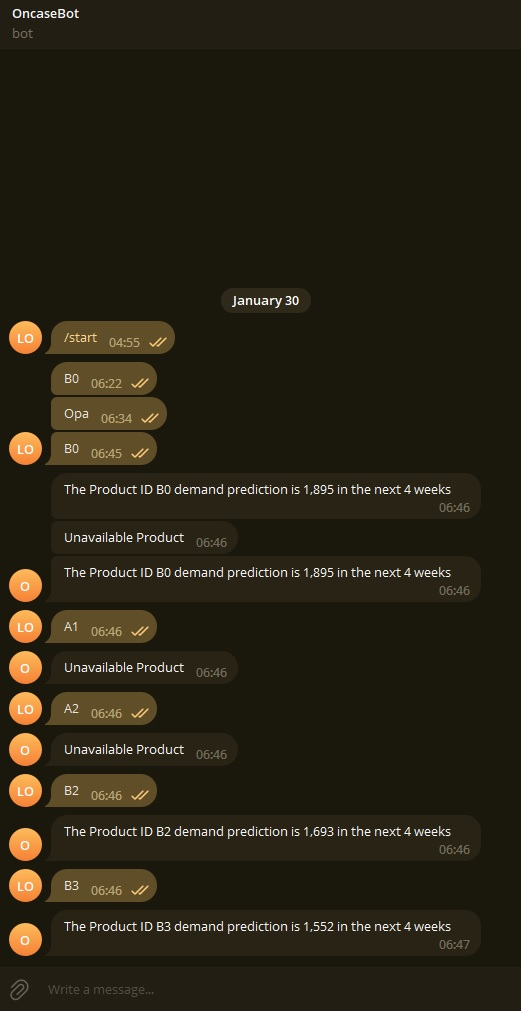

In [315]:
Image('img/Telegram_Bot.jpg')